An improvement and resolution of previous problems


#  FEATURE ENGINEERING AND MODEL DEVELOPMENT

In this notebook, we 
1. Engineer features to model major components of the time series( trends and seasons) and 
2. Build forecasting models 

There are 2 things we must establish before designing forecasting models: 
1. **Available information at the time a forecast is made(features):** 
- In this case: store number, product family, onpromotion, some extra features like holidays and date index(time features can be derived from )
- this can help us avoid a type of data leakage called Lookahead leakage aka "peeking into the future" where info from future is inadvertently used to make predictions in the present.
-  This can happen when features or data that would not be available at the time of prediction are used to train a model. oil price be may an example if we assume that at a point of prediction, 
oil price for the following day is not known. 

2. **The time period during which you require forecasted values(forecast horizon):**
- this can help us make decision on what data to use during training or even the number of lag features to use. 
- we can't add lag features back further than the forecast horizon
- In this case: it's a short-term horizon, just a day into the future. so we can't add lag 2 feature in our model, for example. 

In [97]:
# importations
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


from datetime import datetime, timedelta

from xgboost import XGBRegressor

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import pickle


## Load Data

In [2]:
## Load datasets
store_sales = pd.read_csv("../data/raw/train.csv", 
                   dtype={
                       "store_nbr":"category", 
                       "family":"category",
                       "sales":"float64",
                        "onpromotion":"int32"
                       }, 
                   usecols=["store_nbr", "family", "date", "sales", "onpromotion"],
                   parse_dates=["date"], index_col=False)

holiday_events = pd.read_csv("../data/raw/holiday_events.csv", 
                    dtype={
                        "type":"category",
                        "locale":"category",
                        "locale_name":"category",
                        "description":"category",
                        "transferred":bool
                    },
                    index_col=["date"], 
                    parse_dates=True, 
                    date_format="%Y-%m-%d")
holiday_events = holiday_events.drop(columns=holiday_events.columns[0])

oil = pd.read_csv("../data/processed/01_oil_further_analysis.csv", 
                    index_col=["date"], parse_dates=True, 
                    date_format="%Y-%m-%d" )

stores = pd.read_csv("../data/raw/stores.csv", 
                     dtype={"store_nbr":"category", 
                            "city":"category",
                            "state":"category",
                            "type":"category",
                            "cluster":"category"
                            },
                     index_col=0)

In [3]:
store_sales["date"] = store_sales.date.dt.to_period("D") # change DatetimeIndex to PeriodIndex
store_sales = store_sales.set_index(["store_nbr", "family", "date"]).sort_index()
store_sales

sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.831000            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]

In [4]:
1807220 + 602407

2409627

In [5]:
store_nbr = "1"
family = "AUTOMOTIVE"

store_sales.loc[(store_nbr, family, slice(None))]

sales  onpromotion
date                          
2013-01-01    0.0            0
2013-01-02    2.0            0
2013-01-03    3.0            0
2013-01-04    3.0            0
2013-01-05    5.0            0
...           ...          ...
2017-08-11    1.0            0
2017-08-12    6.0            0
2017-08-13    1.0            0
2017-08-14    1.0            0
2017-08-15    4.0            0

[1684 rows x 2 columns]

- visualizing the sales series across all series is impractical as there are about 1800 series (store-family combinations) 
- to identiy common trends and patterns across different store-famiy combinations, we do an aggregated analysis using average daily sales 
- this can be useful for understanding the overall market trends seasonalities, or other shared characteristics. 
- once we have gained insights from the aggregated data, we perform feature engineering to capture these patterns 
- trade-off here is that we may lose some granularity and the ability to capture nuances specific to individual series. It's a balance between simplicity and detail

In [6]:
## average sales
average_sales = store_sales.groupby("date")["sales"].mean()
average_sales

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
                 ...    
2017-08-11    463.733851
2017-08-12    444.798280
2017-08-13    485.768618
2017-08-14    427.004717
2017-08-15    427.980884
Freq: D, Name: sales, Length: 1684, dtype: float64

Generally a time series is modelled as:

> $series = trend + seasonality + cycle + noise$

- thus, the sum of the time series components (trend + seasonality + cycle) constituting the signal and the noise which is unpredictable

- noise assumed to be normally distributed with mean 0 and constant variance

- The way we approach our problem is to investigate the structure of each component and approapriately engineer features that capture it. 
- These features will then help our ML model to efficiently learn the dynamics in the series.  

## Engineering Trend

- Use moving average plot to understand the structure of the trend in the data
- engineer features to capture the trend in the data


In [7]:
## change default plotting settings

plt.style.use(style='fivethirtyeight') 

plt.rc(
    "figure",             # figure settings
    autolayout=True,
    figsize=(20, 6),
    titleweight="bold",
    titlesize=18,
)

plt.rc(
    "axes",                    # axes settings
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10
)

%config InlineBackend.figure_format = "retina" # increase resolution

plot_params = dict(
    style=".-",
    color="0.75",
    markerfacecolor="0.25",
    markeredgecolor="0.25",
    
)


### Identify Trend
Using moving average plot, we visually investigate the structure of the trend component in our series

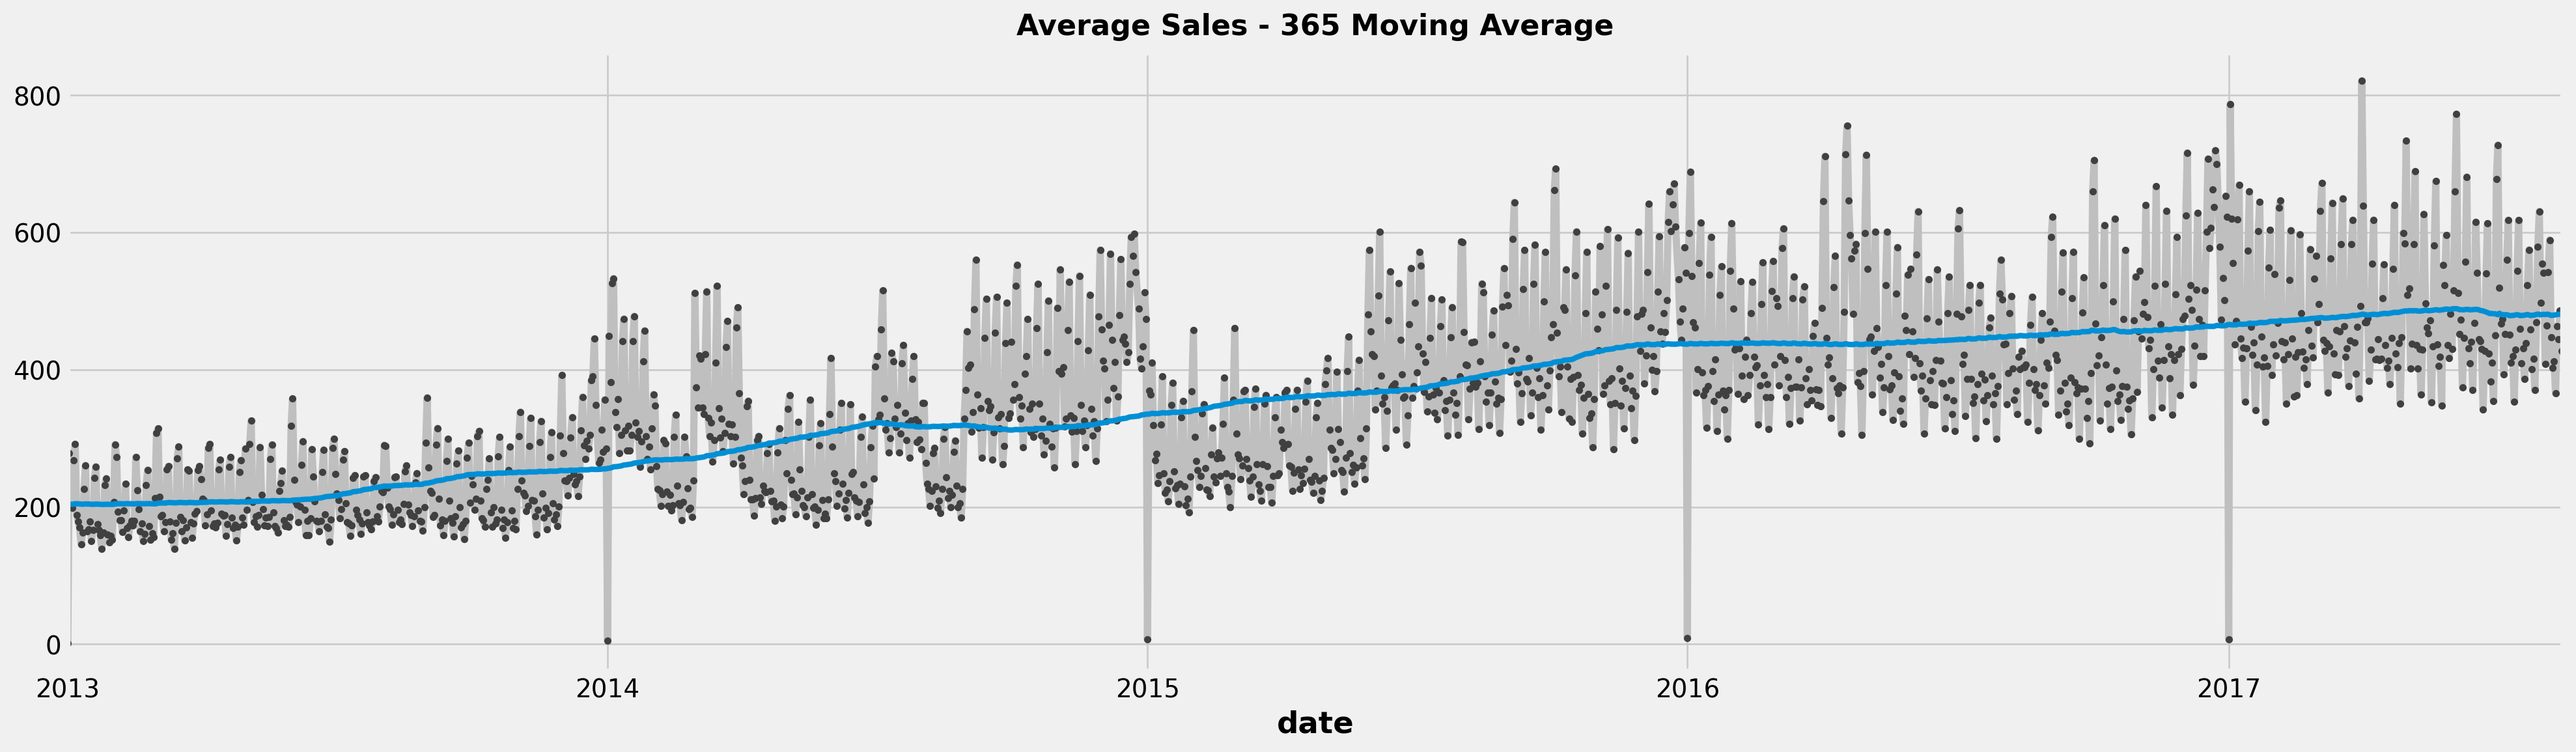

In [8]:
## estimate trend using moving average plot

trend = average_sales.rolling(
    window=365,    # smooth out short-term fluctuations within the year 
    center=True,
    min_periods=183, # min non null values in window to compute average. using half of window size
).mean()


# create MA plot
ax = average_sales.plot(**plot_params)
trend.plot(ax=ax, linewidth=3, legend=False, title="Average Sales - 365 Moving Average");

There seems to be somewhat upward linear trend in the data

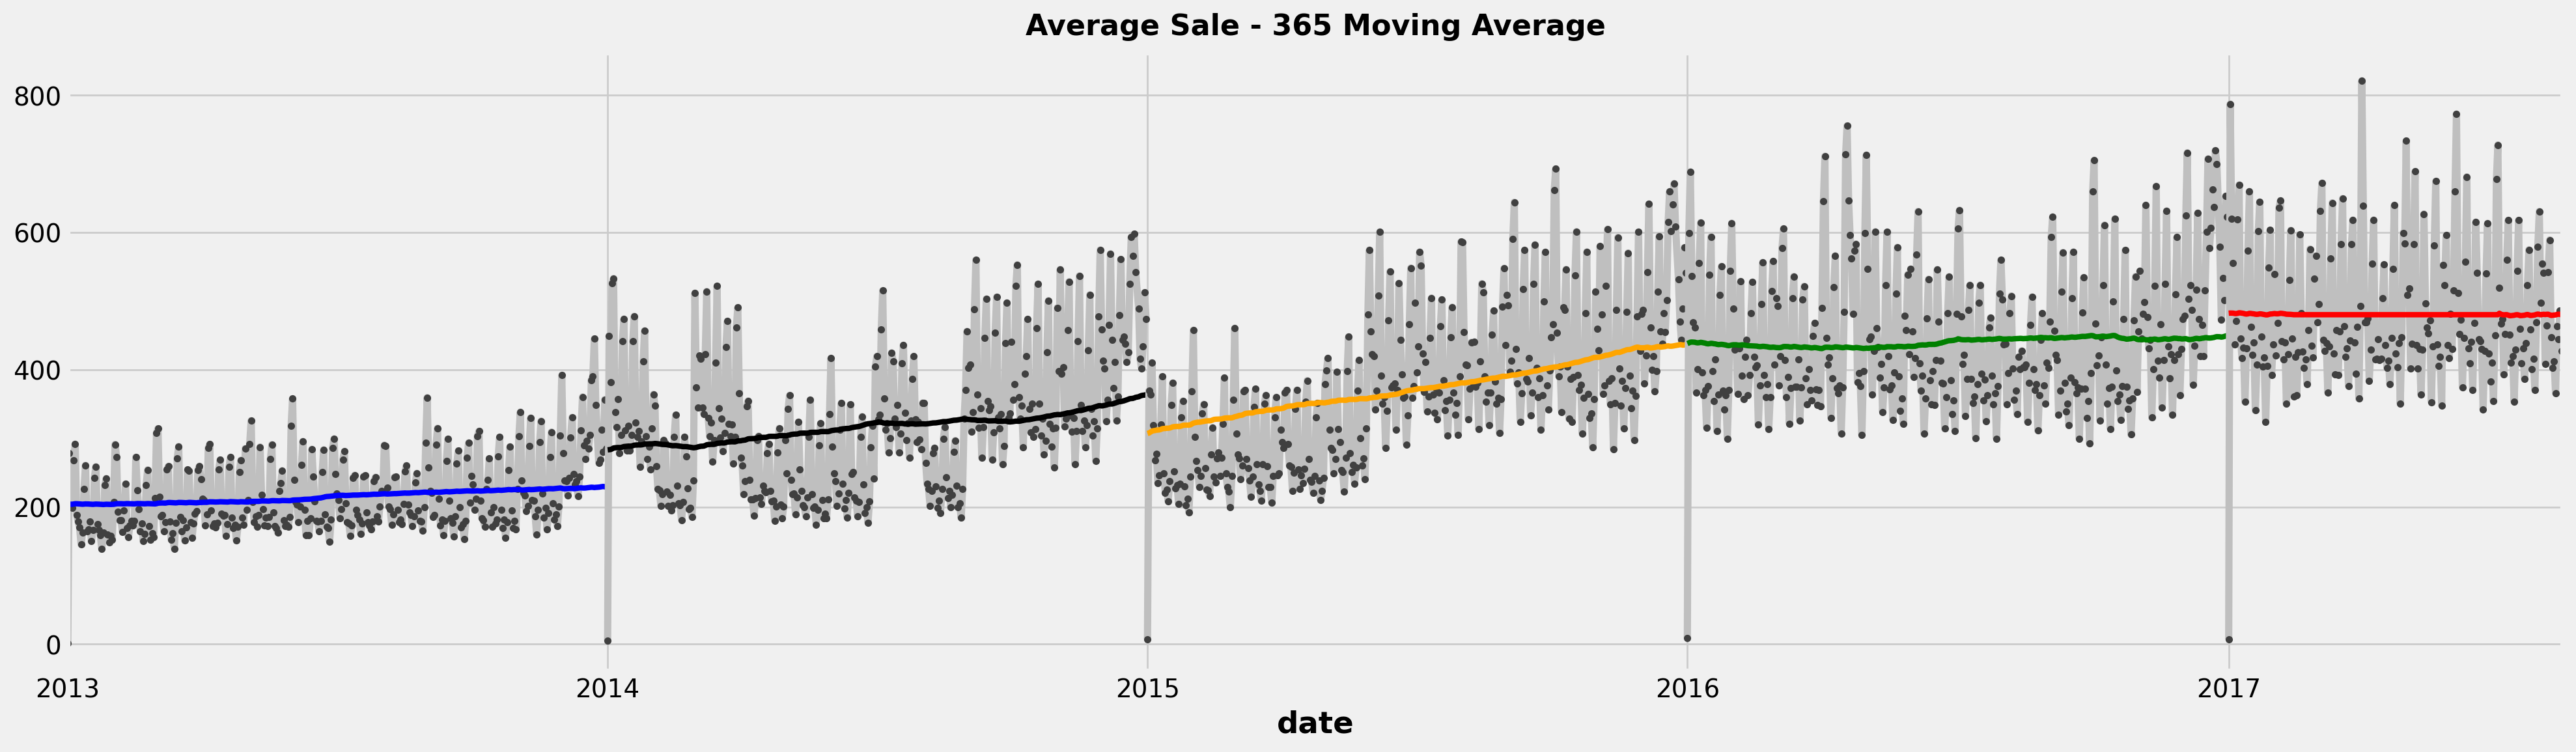

In [9]:
fig, ax = plt.subplots()
colors = ["blue", "black", "orange", "green", "red"]
color_idx = 0
for year in range(2013, 2018):
    series = average_sales.loc[str(year)]
    trend = series.rolling(
        window=365, # smooth out short-term fluctuations
        center=True,
        min_periods=15, 
    ).mean()

    # create MA plot
    ax = series.plot(**plot_params)
    trend.plot(ax=ax, linewidth=3, legend=False, title=f"Average Sale - 365 Moving Average", color = colors[color_idx]);
    color_idx += 1

- Here, we see difference in trend for each year. 
- Particularly for 2017, we notice the trend line is horizontal

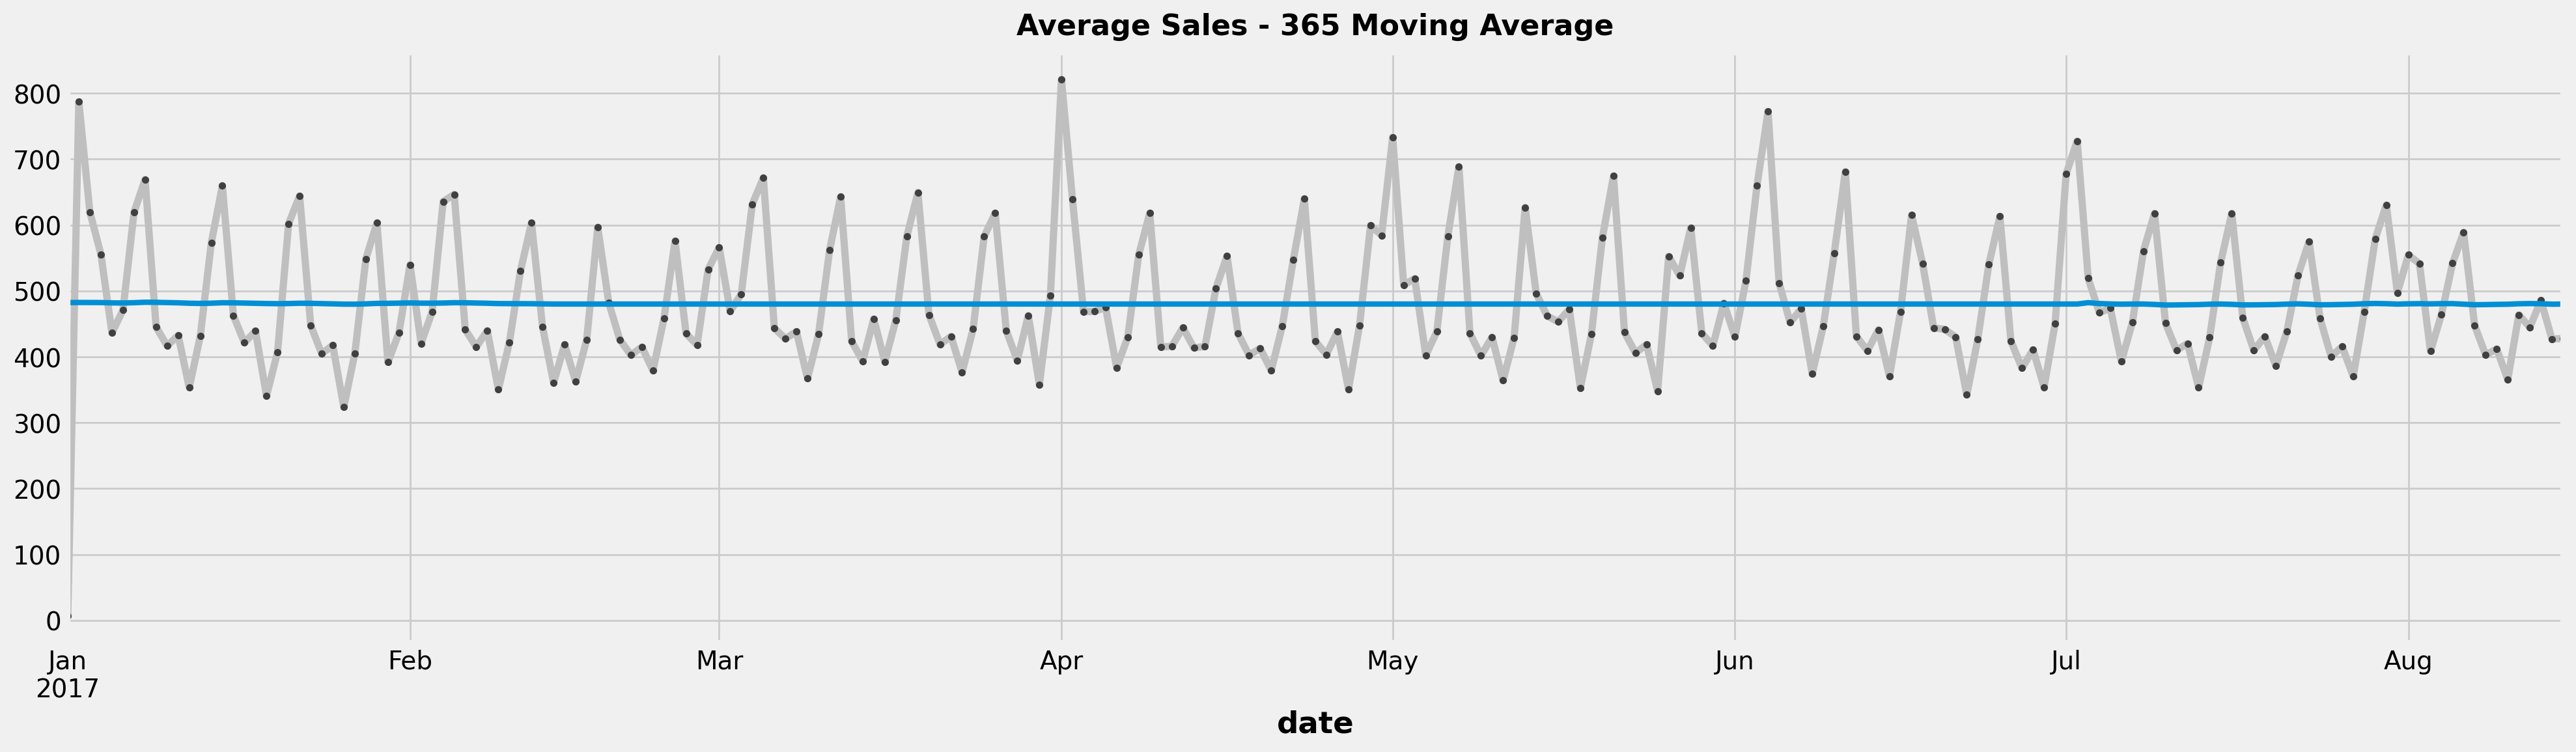

In [10]:
average_sales_2017 = average_sales.loc["2017"]

trend = average_sales_2017.rolling(
    window=365,    # smooth out short-term fluctuations within the year 
    center=True,
    min_periods=183, # min non null values in window to compute average. using half of window size
).mean()


# create MA plot
ax = average_sales_2017.plot(**plot_params)
trend.plot(ax=ax, linewidth=3, legend=False, title="Average Sales - 365 Moving Average");

- Using all available data can provide a comprehensive understanding of the underlying patterns and trends in the time series
-  it is important to keep the goal of our analysis in mind: we're interested in capturing the most current bahaviour and making short-term predictions i.e. forecasting 15 days into the future.
- since the trend in 2017 is significantly different from the preceeding years  
- focusing on the most recent data -- say 2017 data -- may be more relevant since 
- Downside: smaller data which may significantly impact our training and validation set in terms of being large enough to capture the variability and trends of the time series and potentially lead to overfitting


- We proceed to use the most recent data -- 2017. We'll investigate if it's a better approach or to use the entire dataset
- The trend line is horizontal, which indicates that there is no significant upward or downward movement in the data over time. 
- Data points fluctuates around a constant mean value, suggesting a stable behaviour
- Since there is no discernible trend over time, we can focuse on investigating the structure of the seasonality in the data

## Engineering Seasonality 

- use seasonal plots and periodograms to investigate structure of seasonality 
- engineer features to capture seasonality based on insights


### Identify Seasonality

- Just as MA plot can be used to identify trend, seasonal plot, periodograms, or correlograms like acf or pacf can also be used to identify seasonality 
- seasonal plots shows segments of series plotted against some common period, the period being the "season" you want to observe. 
- periodograms show seasonal freq components that are strong in the series. 


In [11]:
## define seasonal plot function

def seasonal_plot(X, y, period, freq, ax=None):
    """generates a seasonal plot showing segments of series plotted against some common period. 

    :param X: feature matrix
    :type X: DataFrame
    :param y: series feature (a column in X)
    :type y: Series
    :param period: season to be observed
    :type period: str (a column in X)
    :param freq: number of observation in a season
    :type freq: str (a column in X)
    :param ax: plotting axes, defaults to None
    :type ax: axes, optional
    :return: a plot
    :rtype: axes
    """
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax





In [12]:
## define periodogram function

def plot_periodogram(ts, detrend='linear', ax=None):
    """_summary_

    :param ts: _description_
    :type ts: _type_
    :param detrend: _description_, defaults to 'linear'
    :type detrend: str, optional
    :param ax: _description_, defaults to None
    :type ax: _type_, optional
    :return: _description_
    :rtype: _type_
    """
    
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


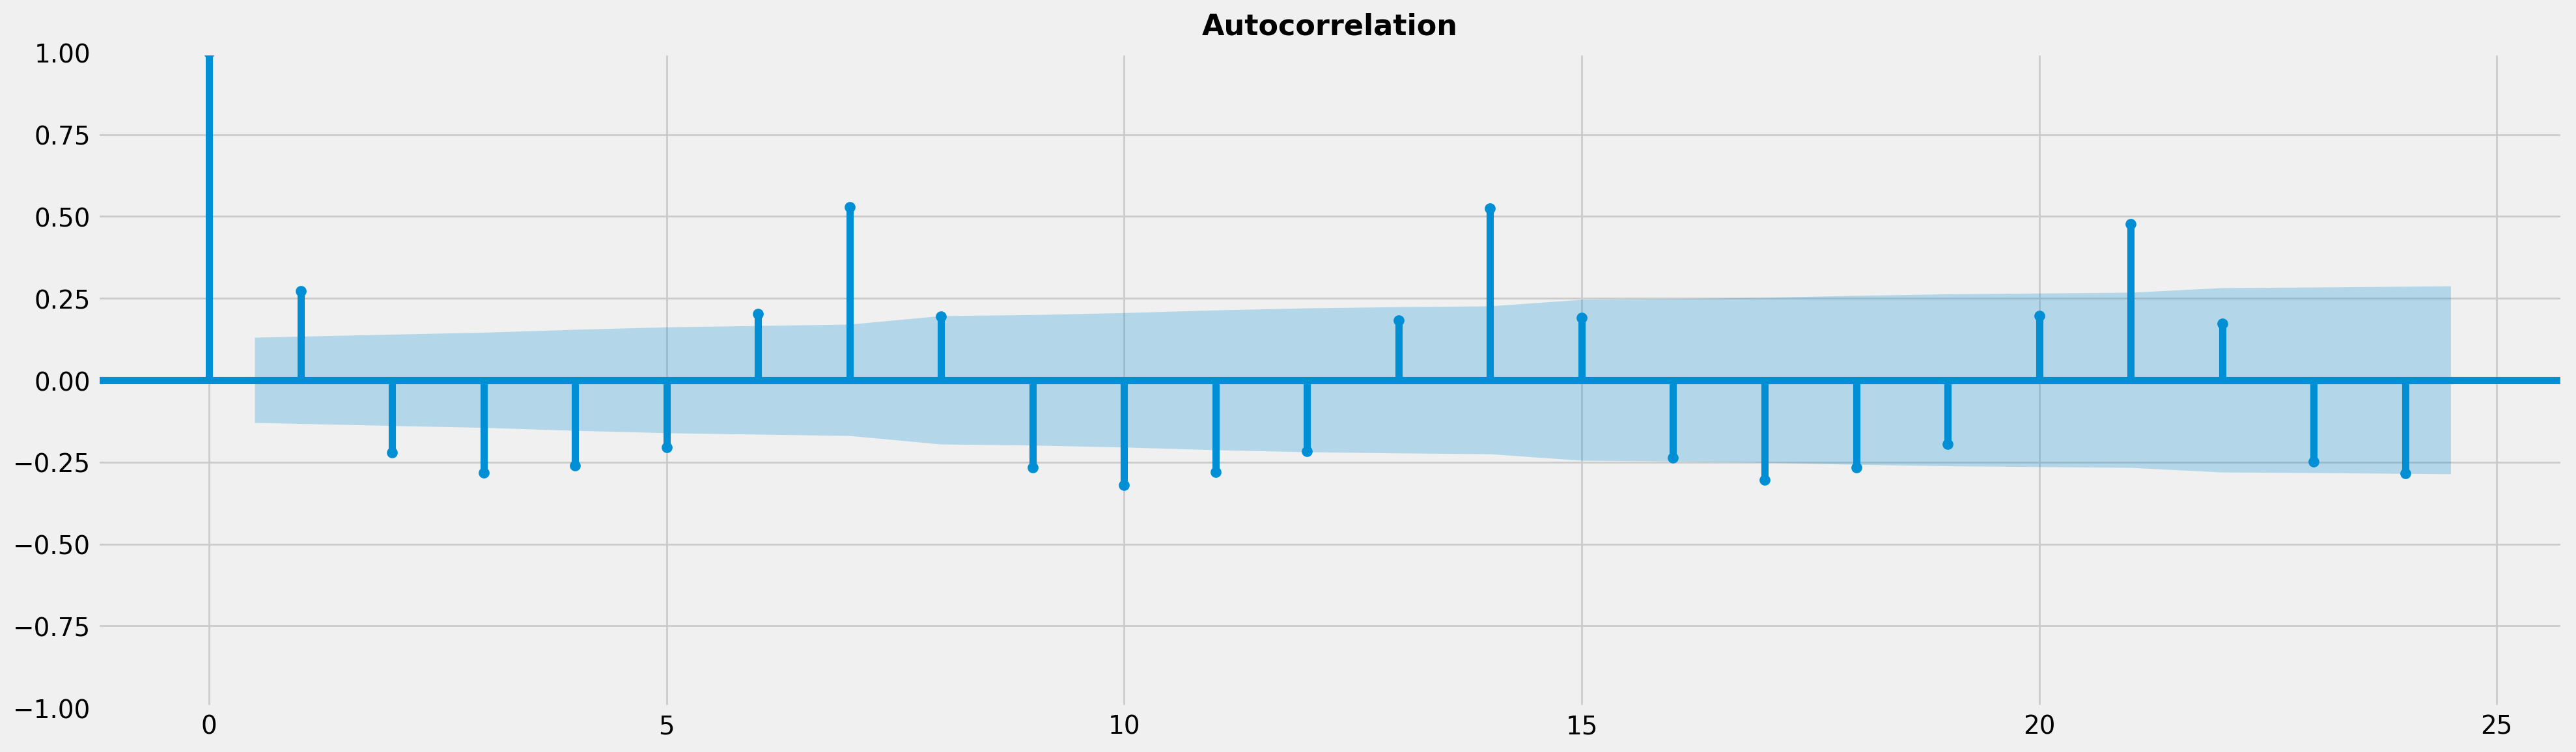

In [13]:
acf_plot = plot_acf(average_sales_2017);

aucocorrelation plot shows presence of strong weekly lags components: a possible indication of weekly seasonality

In [14]:
## visualize weekly season of daily observations

X = average_sales_2017.copy()
X = X.to_frame()

# days within a week
X["day"] = X.index.dayofweek
X["week"] = X.index.week 

X.head()

sales  day  week
date                             
2017-01-01    6.780304    6    52
2017-01-02  786.928379    0     1
2017-01-03  619.740224    1     1
2017-01-04  555.608004    2     1
2017-01-05  436.375395    3     1

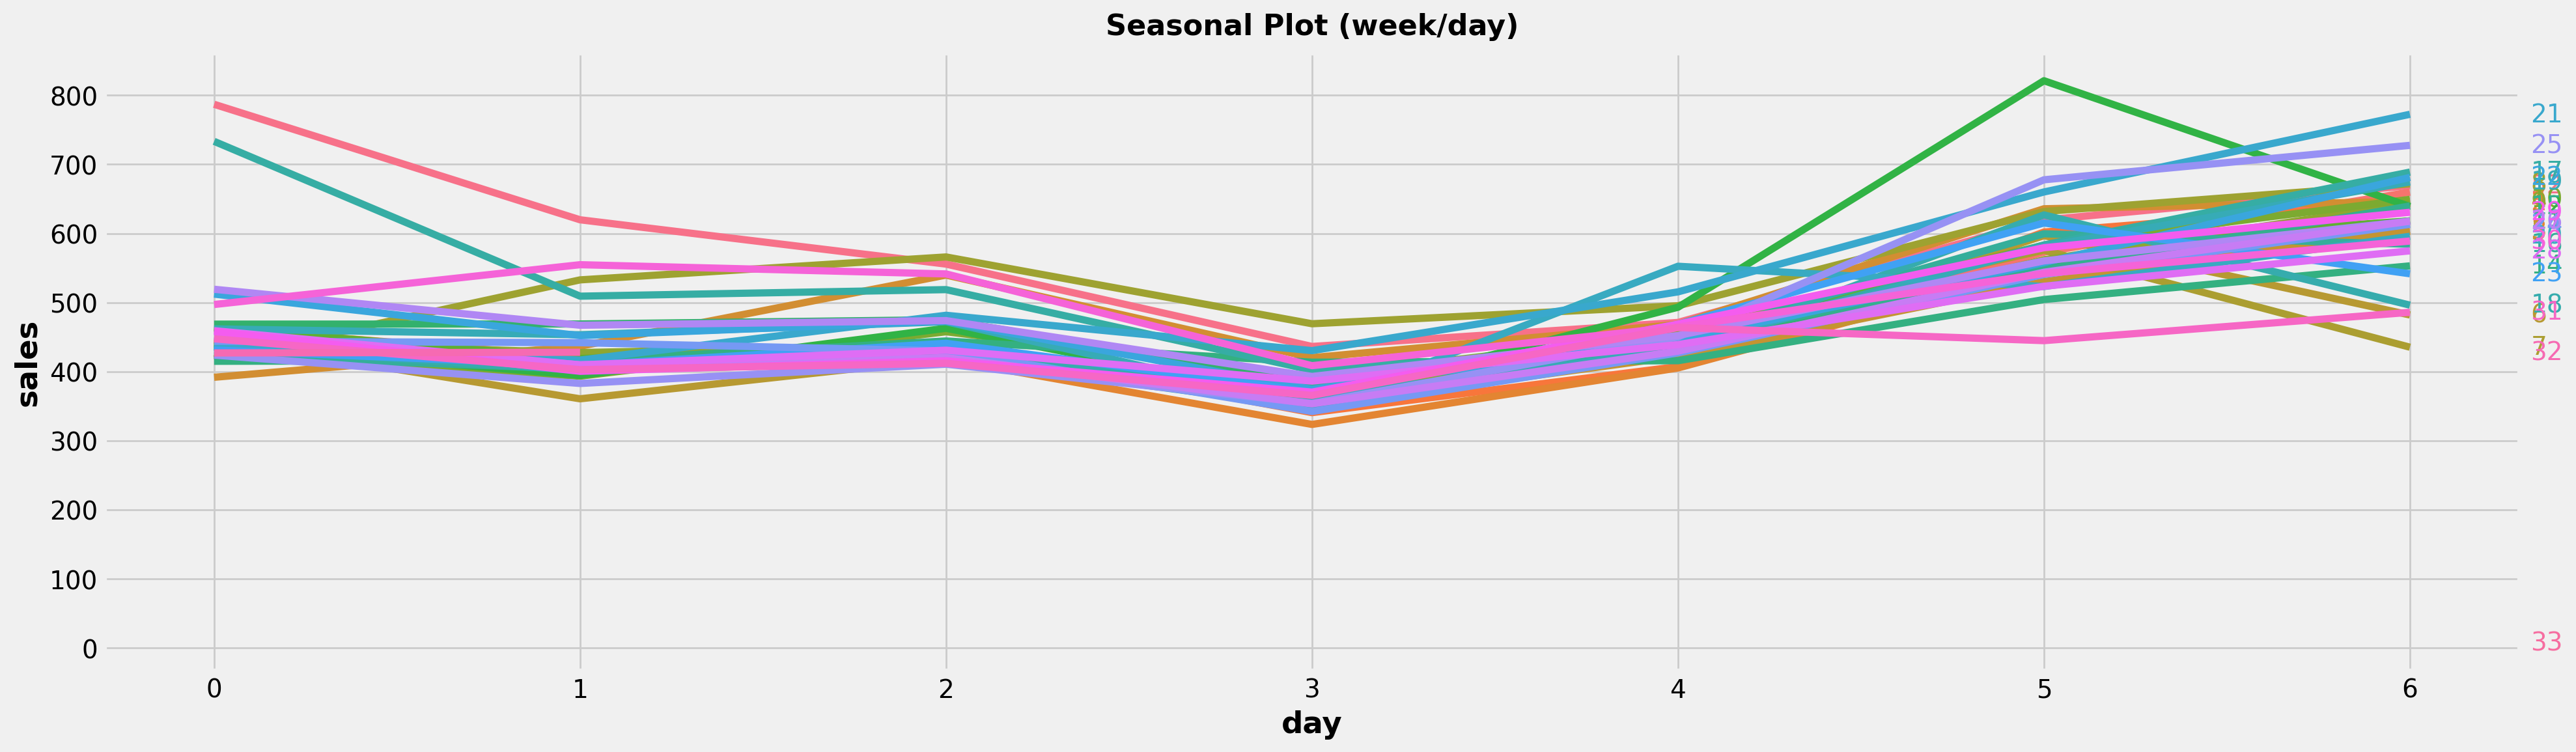

In [15]:
fig, ax = plt.subplots()

seasonal_plot(X=X, y="sales", period="week", freq="day", ax=ax);

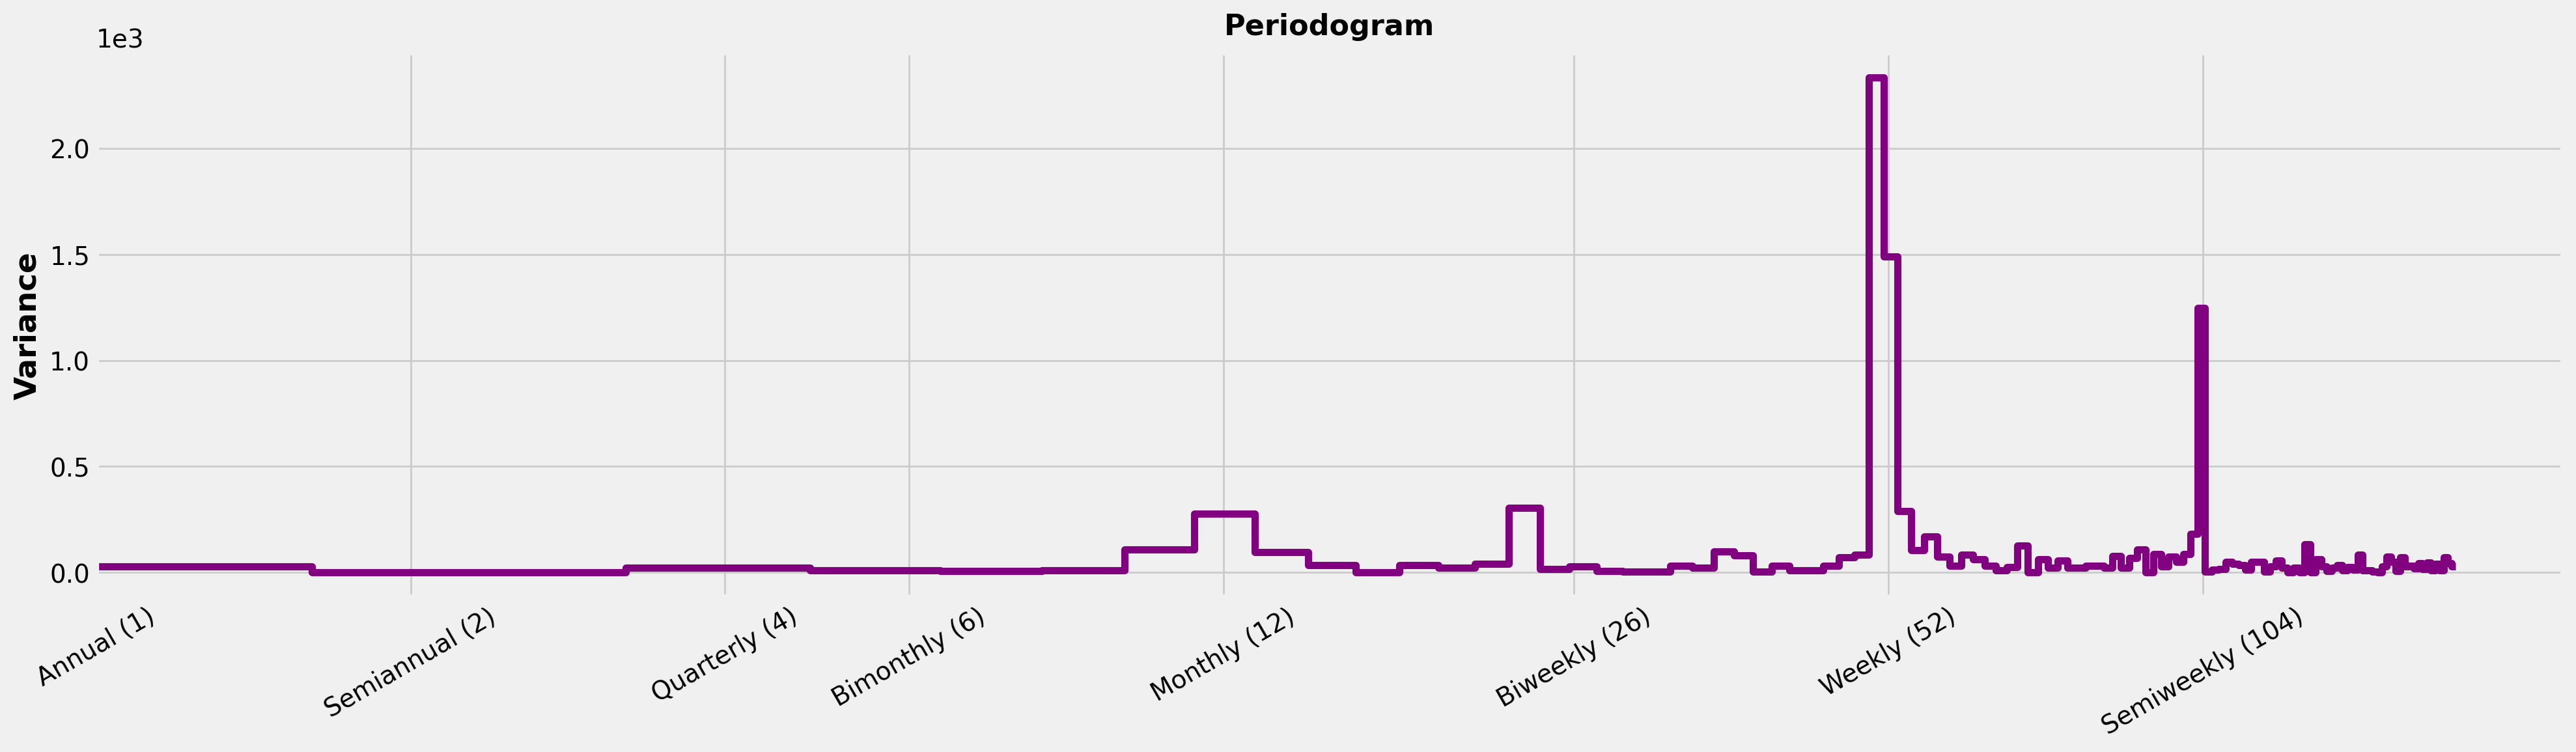

In [16]:
plot_periodogram(X.sales);

- Both seasonal plot and periodogram suggest a strong weekly seasonality. 
- From the periodogram, it appears there may be some monthly and biweekly components as well. 
- In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.


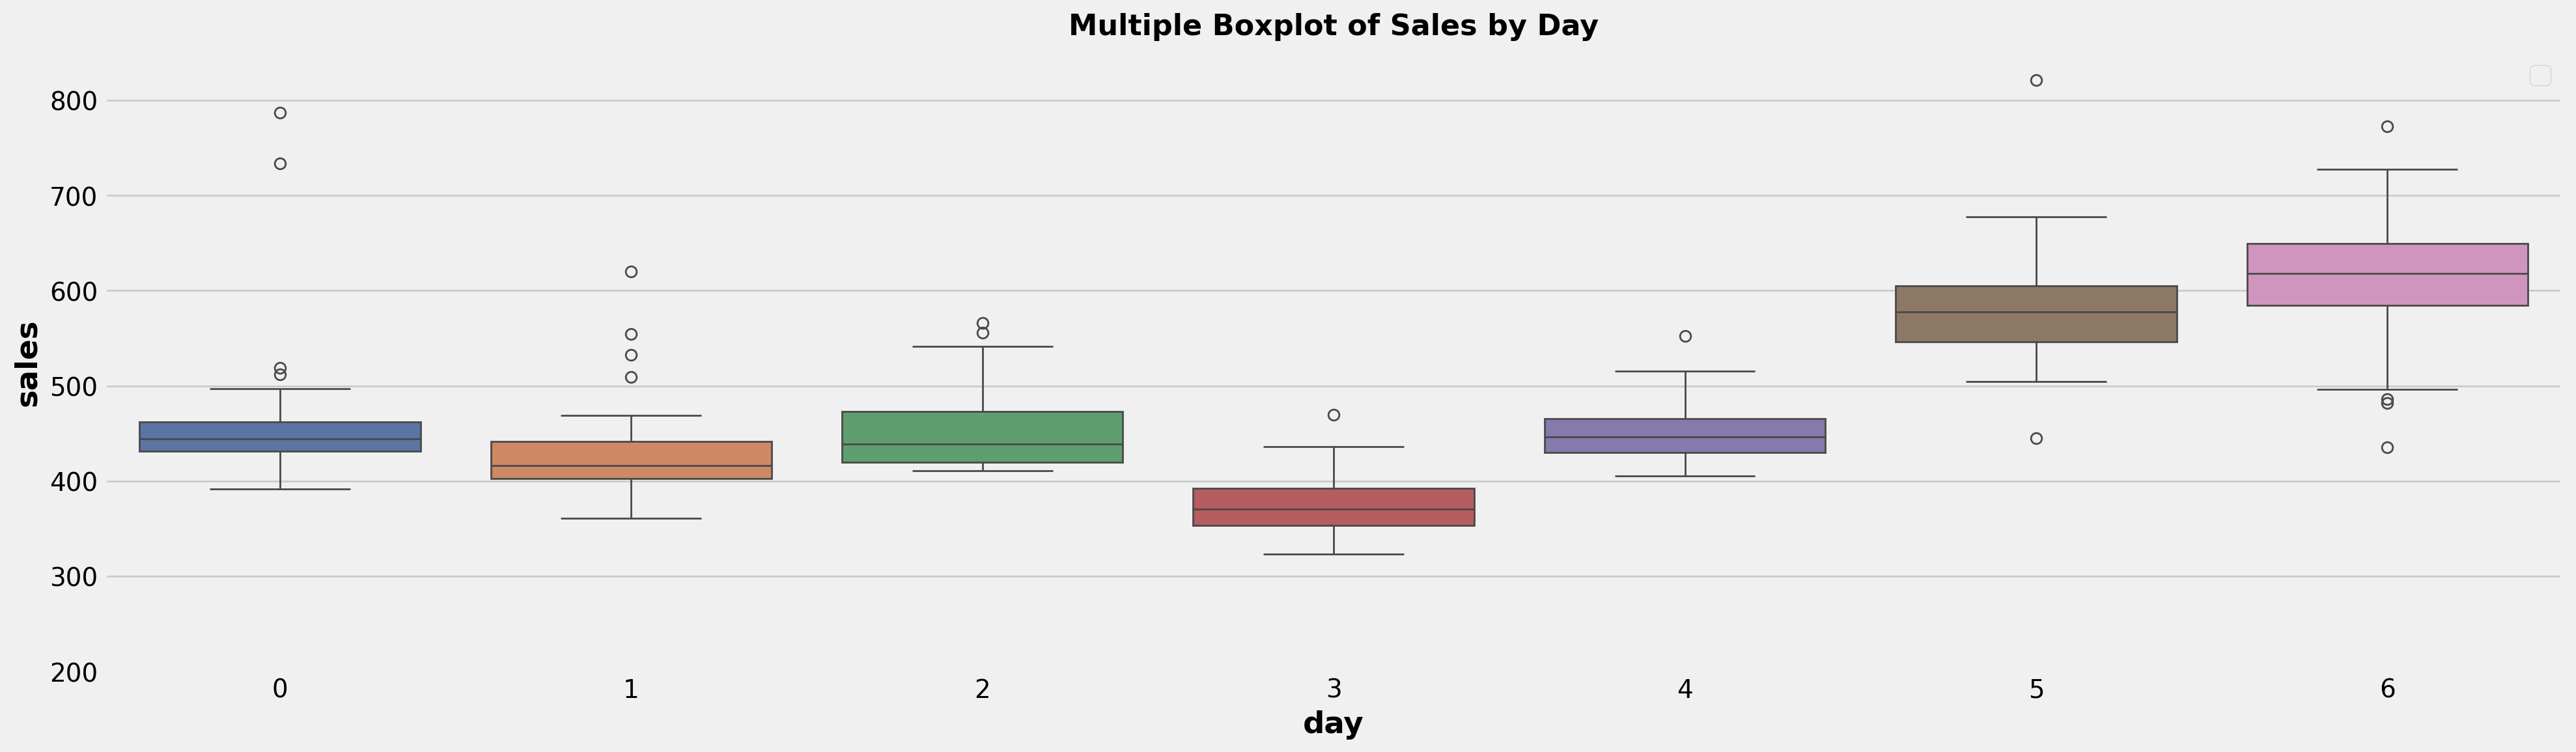

In [17]:
ax = sns.boxplot(data=X, x="day", y="sales", hue="day", palette="deep")
ax.set_ylim(bottom=200, top=850)
ax.set_title("Multiple Boxplot of Sales by Day")
ax.legend([]);

- outliers may be legitimate values explainable by factors such as holidays or oil prices
- based on insights we may delete them or engineer features, such as holiday features to explain these outliers to our model 
- There's a significant difference between the means of sales for each day. 
- Including weekly seasonal features could our model 

### Create Seasonal Features

- we explore different ways of creating seasonal features


### Train/Test split
- The split should preserve the temporal order and structure of the data
- validation set should be large enough to capture the variability and trends of the time series.
- We use a common rule of thumb: use 80% of the data for training and 20% for testing.

In [18]:
y = average_sales_2017.copy()
train_idx, eval_idx = train_test_split(y.index, test_size=.2, shuffle=False)
X_train, X_eval = y.loc[train_idx], y.loc[eval_idx]

In [19]:
print("train set:", X_train.shape)
print("evaluation set:", X_eval.shape)

train set: (181,)
evaluation set: (46,)



- Hopefully, the evaluation size of 41 samples is sufficient to capture the variability in the data. 

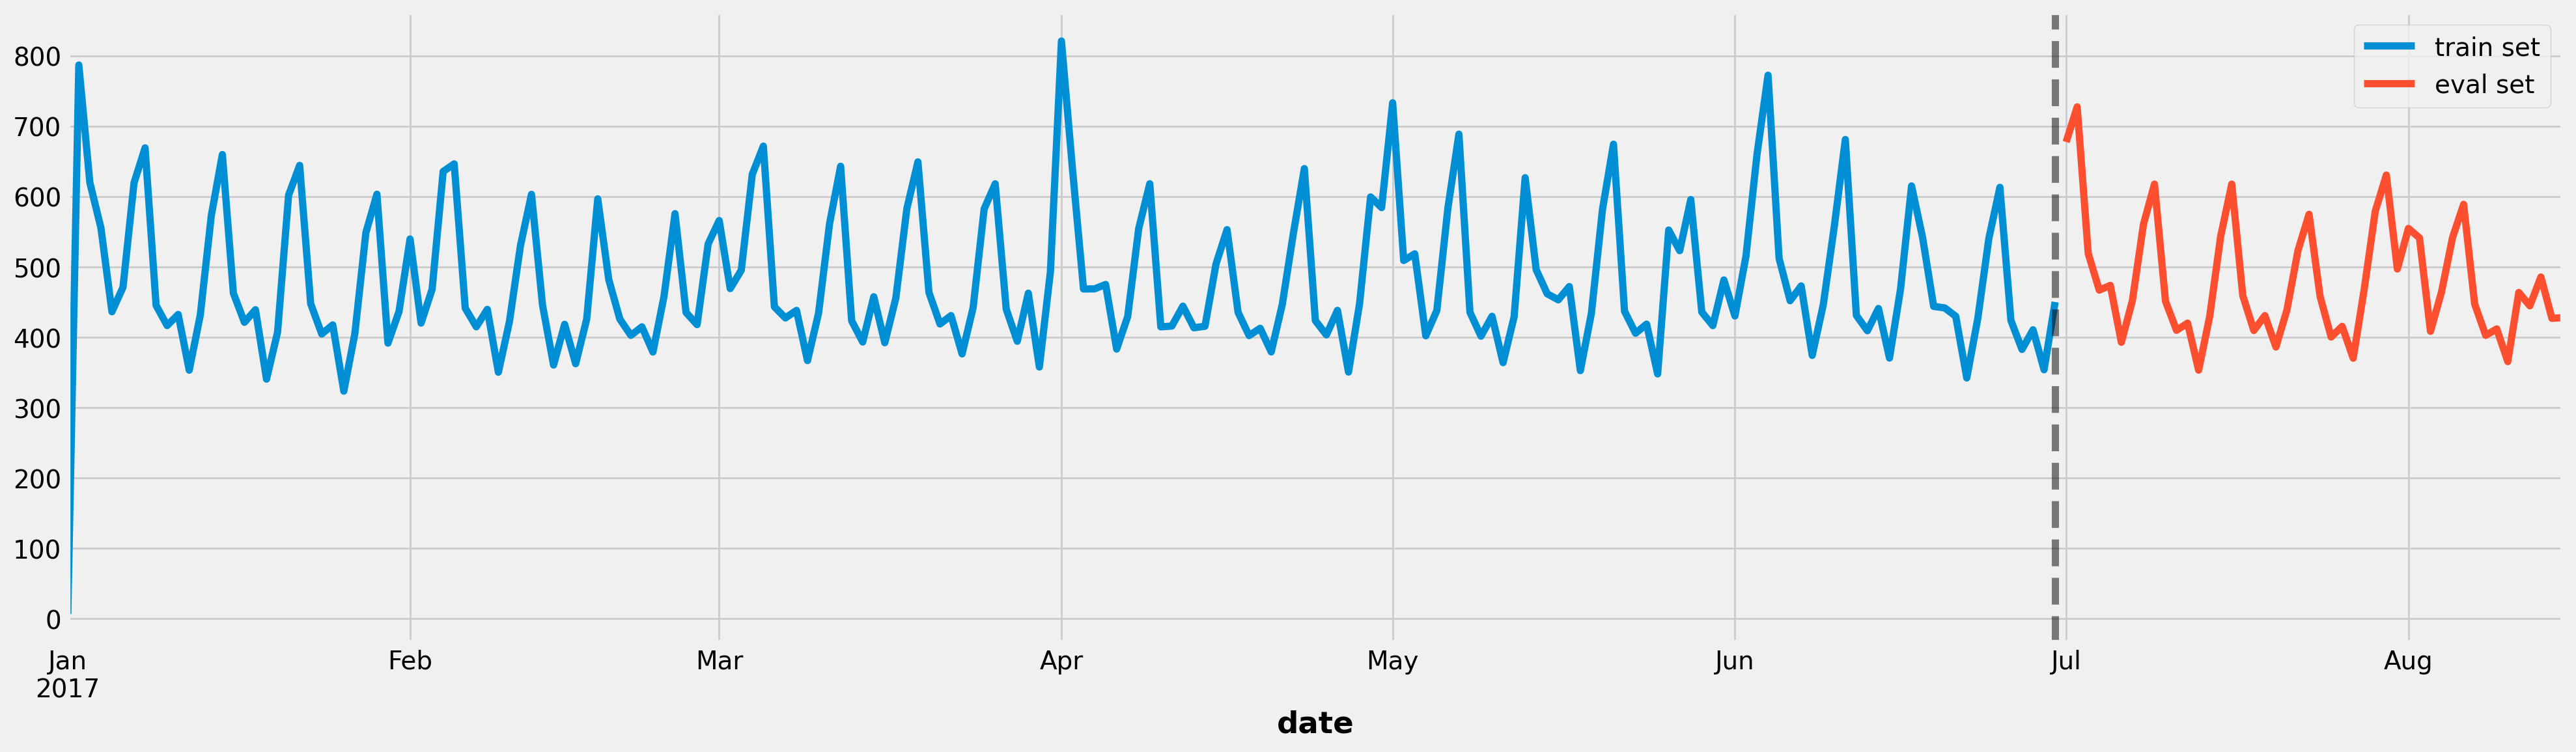

In [20]:
ax = X_train.plot(label="train set")
X_eval.plot(ax=ax, label="eval set")
plt.axvline(x=X_train.index[-1], color="k", linestyle="--", alpha=0.5)
ax.legend();

- There are various ways of engineering seasonal features for a forecasting task. 
- Let's begin with the simplest seasonal features and model 

### First set of features: X_1

In [21]:
## create weekly and daily seasonal features
y_train = y.loc[train_idx]
y_eval = y.loc[eval_idx]

def create_features(series):
    
    X = pd.DataFrame()

    X["day"] =  series.index.day_of_week
    X["week"] = series.index.week
    X.index = series.index
    
    return X 

X_1 = create_features(y_train)
X_1

day  week
date                 
2017-01-01    6    52
2017-01-02    0     1
2017-01-03    1     1
2017-01-04    2     1
2017-01-05    3     1
...         ...   ...
2017-06-26    0    26
2017-06-27    1    26
2017-06-28    2    26
2017-06-29    3    26
2017-06-30    4    26

[181 rows x 2 columns]

In [22]:
## create features for evaluation set

X_1_eval = create_features(y_eval)
X_1_eval.head()

day  week
date                 
2017-07-01    5    26
2017-07-02    6    26
2017-07-03    0    27
2017-07-04    1    27
2017-07-05    2    27

### Train model and make predictions

In [23]:
## define function to train model 

def fit_predict(X_train, y_train, X_eval, model):
    
    """function to train and predict in and out of sample

    :return: in and out sample predictions
    :rtype: pandas series
    """


    fitted_model = model.fit(X_train, y_train)

    y_preds = pd.Series(
        fitted_model.predict(X_train),
        index=X_train.index,
        name="In sample"
    )
    
    y_fore = pd.Series(
        fitted_model.predict(X_eval),
        index=X_eval.index,
        name="Out of sample"
        
    )

    return y_preds, y_fore



In [24]:
## make predictions using a linear regression model 

y_preds, y_fore = fit_predict(X_train=X_1, y_train=y_train, X_eval=X_1_eval, 
                              model=LinearRegression())



### Visualize predictions

In [25]:
## define funciton to plot predictions

def plot_predictions(series, y_preds, y_fore):
    
    ax = series.plot(**plot_params, alpha=0.7, 
                                title="2017 Average sales", 
                                ylabel="items sold")
    y_preds.plot(ax=ax, label="In sample predicitons")
    y_fore.plot(ax=ax, label="Out of sample predictions")
    ax.legend();

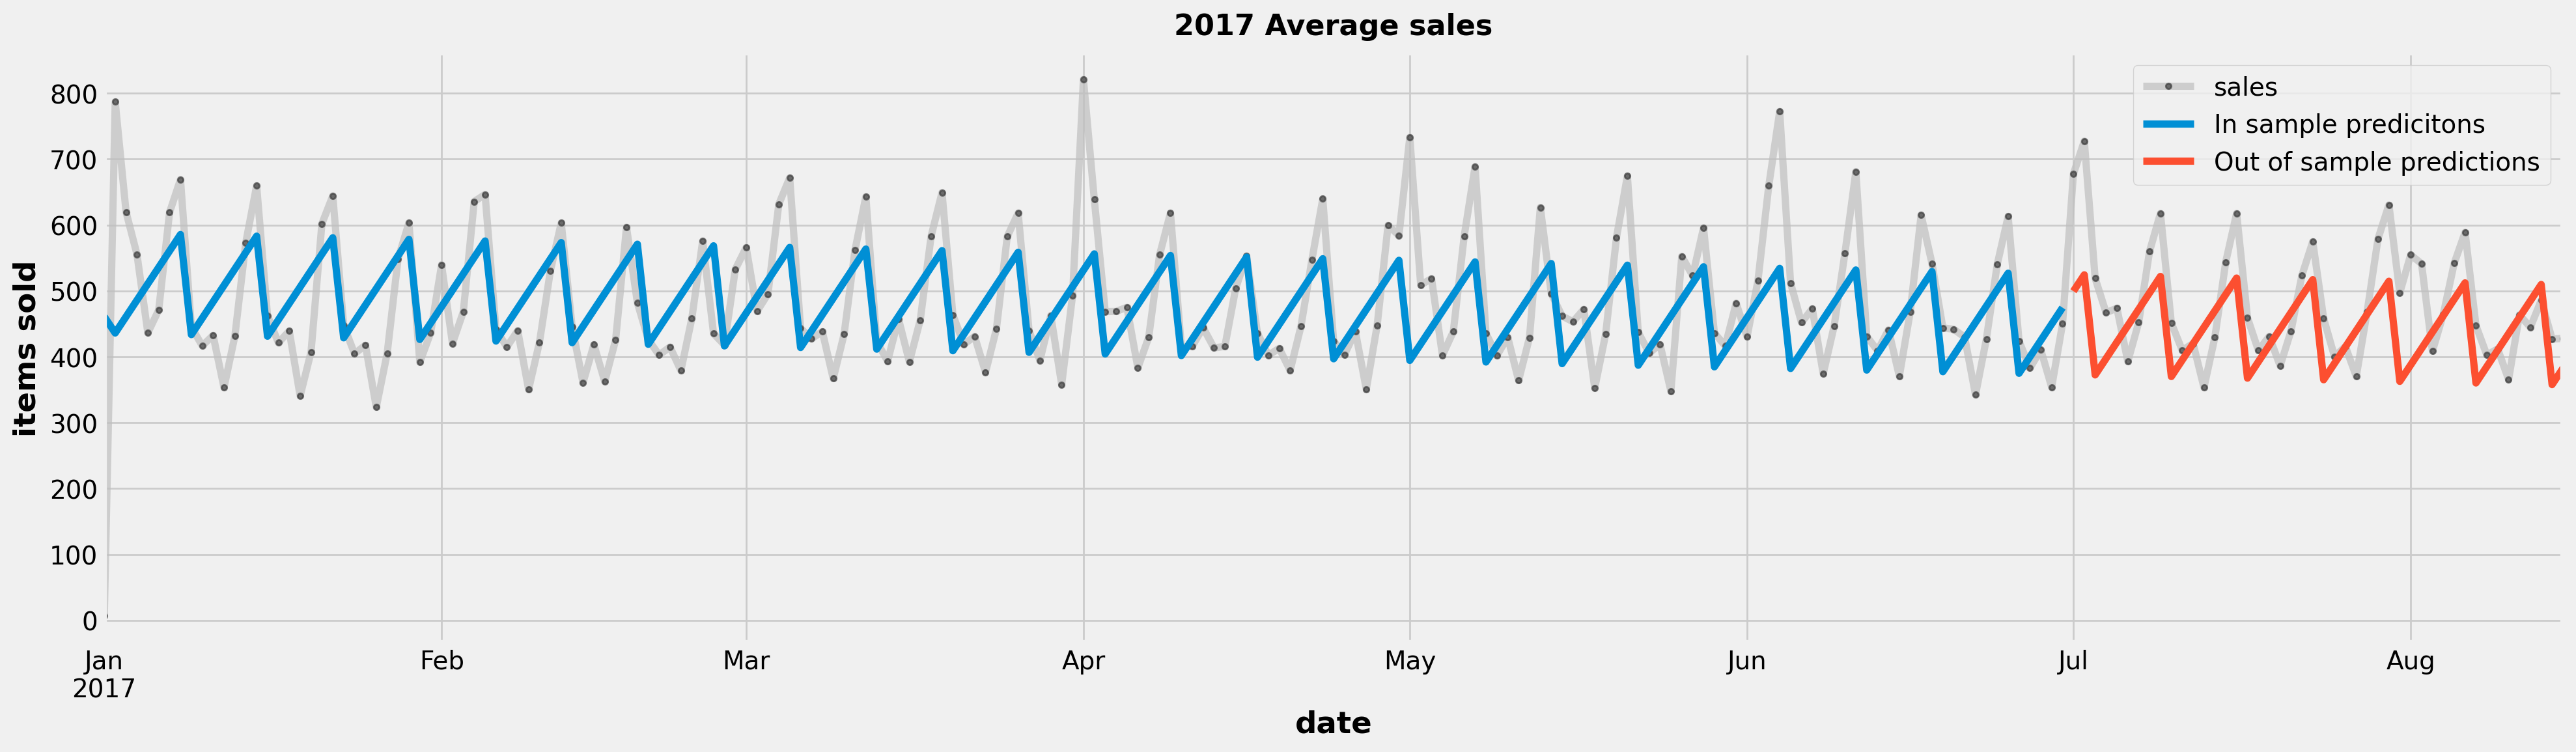

In [26]:
## plot in sample and out of sample predictions
plot_predictions(series=y, y_preds=y_preds, y_fore=y_fore)

- Our predictions seem to follow the pattern in the series. 
- However, there seem to be more to learn.
- But, how can we tell if our model has sufficiently learned the components of the series and there's no more improvements that can be made?
- we use the concept of gaussian white noise








### White Noise
A time series is said to be white noise if: 

1. mean is zero
2. std is constant over time
3. corr between lags is 0 (no autocorrelation)

<img src="img/ts-pp-gwn.jpg">


- white noise is not predictable. random, independent, no pattern, no correlation or outliers
- time series models are generally represented as: $y_t = signal + noise$
- if we can show that the residuals of our model is white noise, then we can conclude that we have sufficiently learned from the time series 
- we may test if the residuals are white noise using: 
1. visual inspections
2. check ACF. correlogram should show that lags are not sifnificant or near insignificance 
3. statistical tests, eg: Ljung-box test



### Evaluate model performance and plot residuals

- The Mean Absolute Percentage Error (MAPE) is a measure of the accuracy of a forecasting or prediction method. 
- It calculates the average of the absolute percentage differences between predicted and actual values. 

- With a small sample size, the model's performance on the evaluation set may not be a reliable indicator of its true generalization performance.
- we use additional metrix in conjunction with RMSLE for a comprehensive assessment of forecasting

In [27]:
## evaluate performance

def score_dataset(y_true, y_pred):

    print(
        f"MAPE: {np.mean(np.abs((y_true - y_pred) / y_true)) * 100:.3f}"
    )
    print( 
          f"RMSLE: {np.sqrt(mean_squared_log_error(y_true,  y_pred)):.3f}" 
        )
    
print("model performance with seasonal features from datetime index")
score_dataset(y_true=y_eval, y_pred=y_fore)

model performance with seasonal features from datetime index
MAPE: 12.439
RMSLE: 0.165


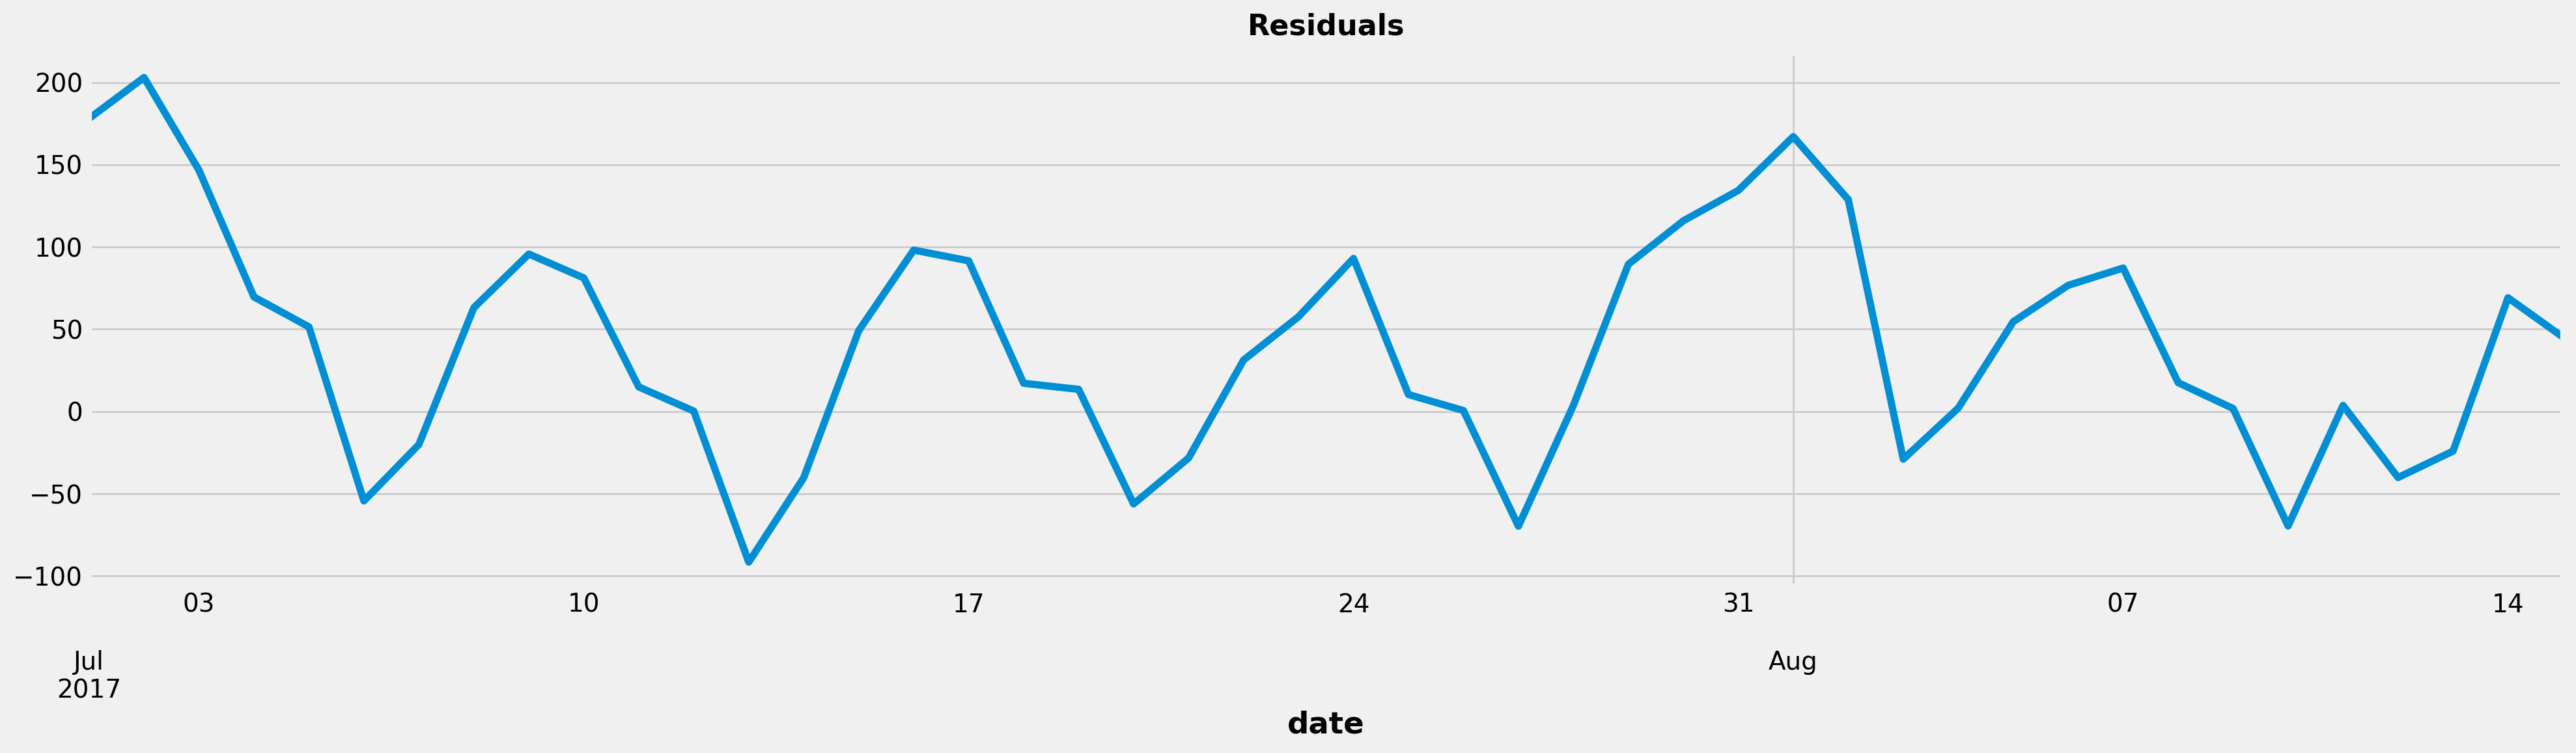

In [28]:
residuals = y_eval - y_fore
residuals.plot(title="Residuals");

- By visual inspection, it's clear there's some pattern still in the plot
- thus, the residuals isn't white noise
 

- This will serve as our baseline model 
- We'll build upon this to develop a more complex or hybrid models to handle the entire dataset

Second set of features: X_2 

- create seasonal indicators for weekly seasons
- create fourier features of order 4 for monthly seasons: i.e create sin/cos curve patterns that repeat 4 times or less a Month. 
- we'll create our seasonal features using DeterministicProcess. 
- We use two seasonal periods(monthly and weekly) 

- when we check the plot of the series, we that there is a signicant dip in sales duing every new year day. 
- We include a feature to learn this

In [29]:

fourier = CalendarFourier(freq="M", order=4)   # for fourier features

dp = DeterministicProcess(
    index=y_train.index,
    order=1, #  exclude trend feature
    constant=True,  # bias
    seasonal=True,  # generate seasonal indicators or dummy
    additional_terms=[fourier],
    drop=True,    
)
 
X_2 = dp.in_sample()
X_2["NewYear"] = (X_2.index.dayofyear == 1)  # take care of the dip in sales at the beginning of the year
X_2.head()

const  trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                       
2017-01-01    1.0    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    1.0    2.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-01-03    1.0    3.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-01-04    1.0    4.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-01-05    1.0    5.0     0.0     0.0     0.0     1.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
date                                                                     
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-02       0.201299       0.979530       0.394356       0.918958   
2017-01-03       0.394356       0.918958       0.724793       0.688967   
2017-01-04       0.571268       0.820763       0.937752       0.347305   
2017-01-05       0.724793       0.688967       0.998717      -0.050649   

            sin(3,freq=M)  cos(3,freq=M)  sin(4,freq=M)  cos(4,freq=M)  \
date                                                                     
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-02       0.571268       0.820763       0.724793       0.688967   
2017-01-03       0.937752       0.347305       0.998717      -0.050649   
2017-01-04       0.968077      -0.250653       0.651372      -0.758758   
2017-01-05       0.651372      -0.758758      -0.101168      -0.994869   

            NewYear  
date                 
2017-01-01     True  
2017-01-02    False  
2017-01-03    False  
2017-01-04    False  
2017-01-05    False

In [30]:
## create evaluation feature matrix 


X_2_eval = dp.out_of_sample(steps=len(y_eval.index))
X_2_eval["NewYear"] = (X_2_eval.index.dayofyear == 1) # capture new year day sales trend
X_2_eval.head()

const  trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
2017-07-01    1.0  182.0     0.0     0.0     0.0     0.0     0.0     1.0   
2017-07-02    1.0  183.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-07-03    1.0  184.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-07-04    1.0  185.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-07-05    1.0  186.0     0.0     0.0     1.0     0.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
2017-07-01       0.000000       1.000000       0.000000       1.000000   
2017-07-02       0.201299       0.979530       0.394356       0.918958   
2017-07-03       0.394356       0.918958       0.724793       0.688967   
2017-07-04       0.571268       0.820763       0.937752       0.347305   
2017-07-05       0.724793       0.688967       0.998717      -0.050649   

            sin(3,freq=M)  cos(3,freq=M)  sin(4,freq=M)  cos(4,freq=M)  \
2017-07-01       0.000000       1.000000       0.000000       1.000000   
2017-07-02       0.571268       0.820763       0.724793       0.688967   
2017-07-03       0.937752       0.347305       0.998717      -0.050649   
2017-07-04       0.968077      -0.250653       0.651372      -0.758758   
2017-07-05       0.651372      -0.758758      -0.101168      -0.994869   

            NewYear  
2017-07-01    False  
2017-07-02    False  
2017-07-03    False  
2017-07-04    False  
2017-07-05    False

### Train model and make predictions

We set the `fit_intercept` parameter of the Linear Reg model to False and the bias is catered for in the `DeterministicProcess`

In [31]:
## make predictions 

y_preds, y_fore = fit_predict(X_train=X_2, y_train=y_train, X_eval=X_2_eval,
                              model=LinearRegression(fit_intercept=False))

### visualize predicitons

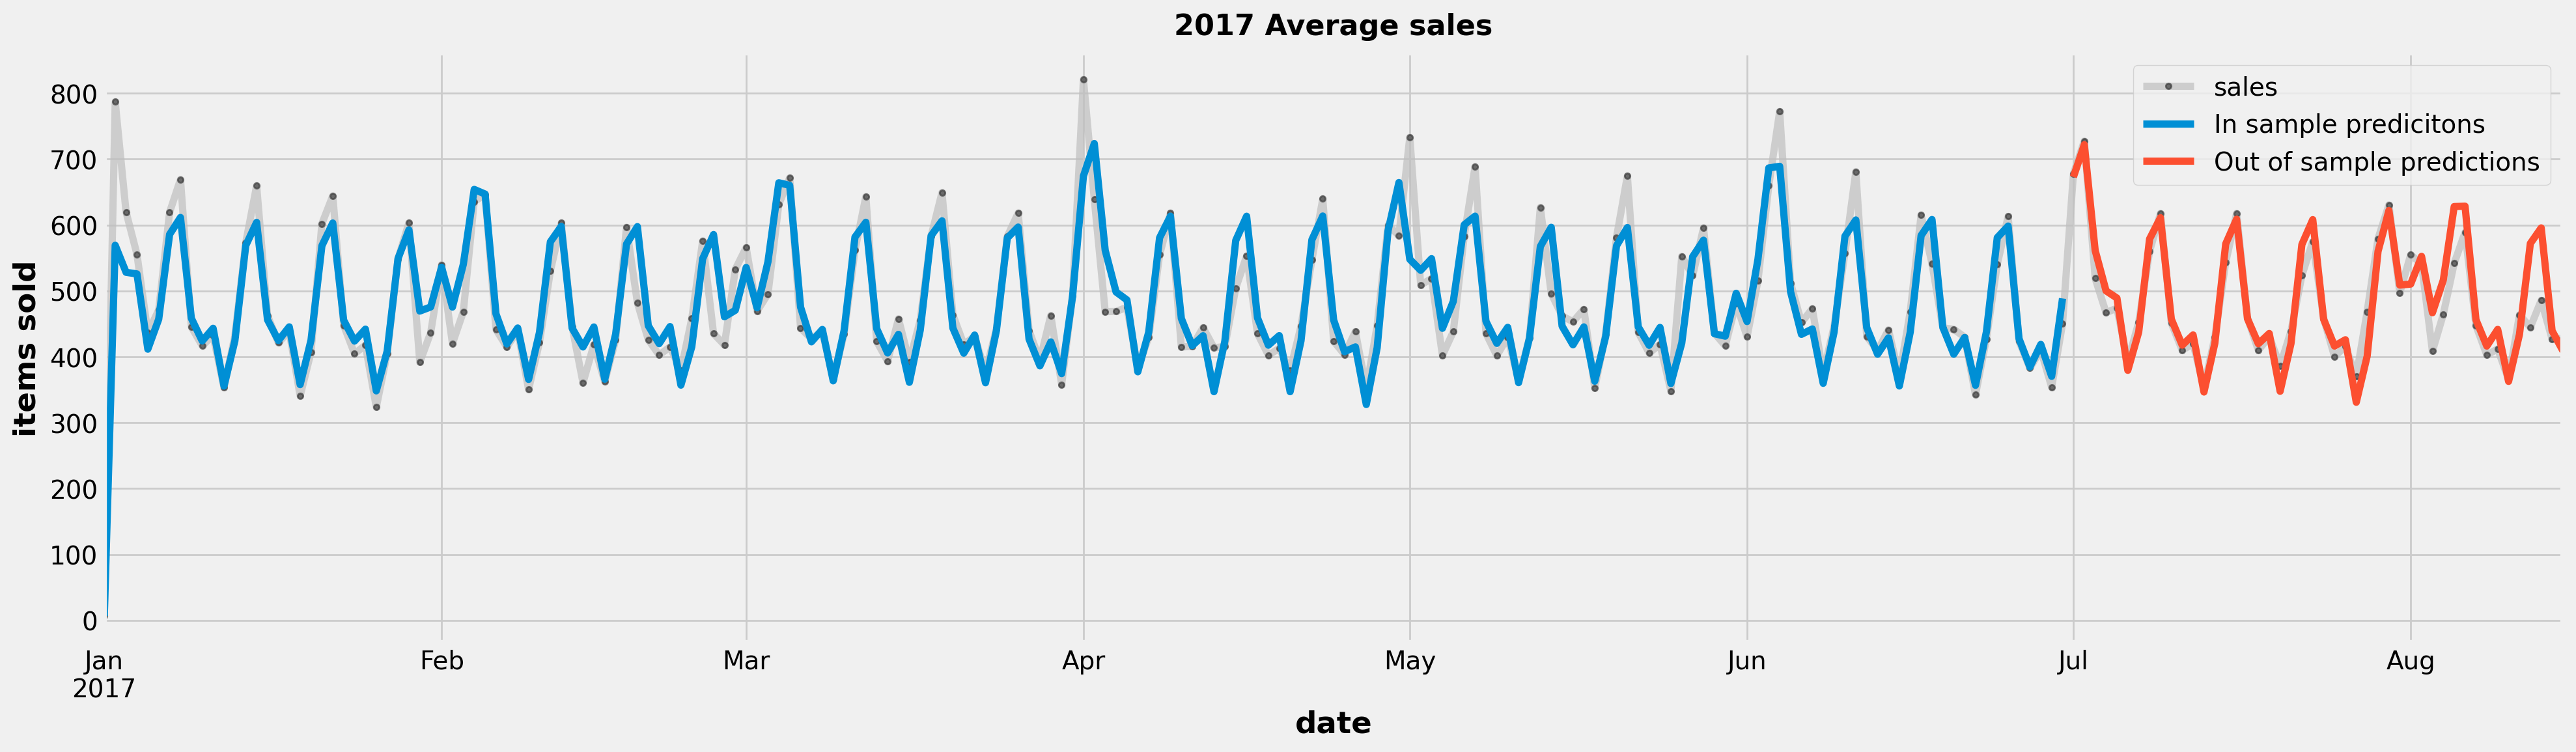

In [32]:
plot_predictions(series=y, y_preds=y_preds, y_fore=y_fore)

### Evaluate model performance and plot residuals 

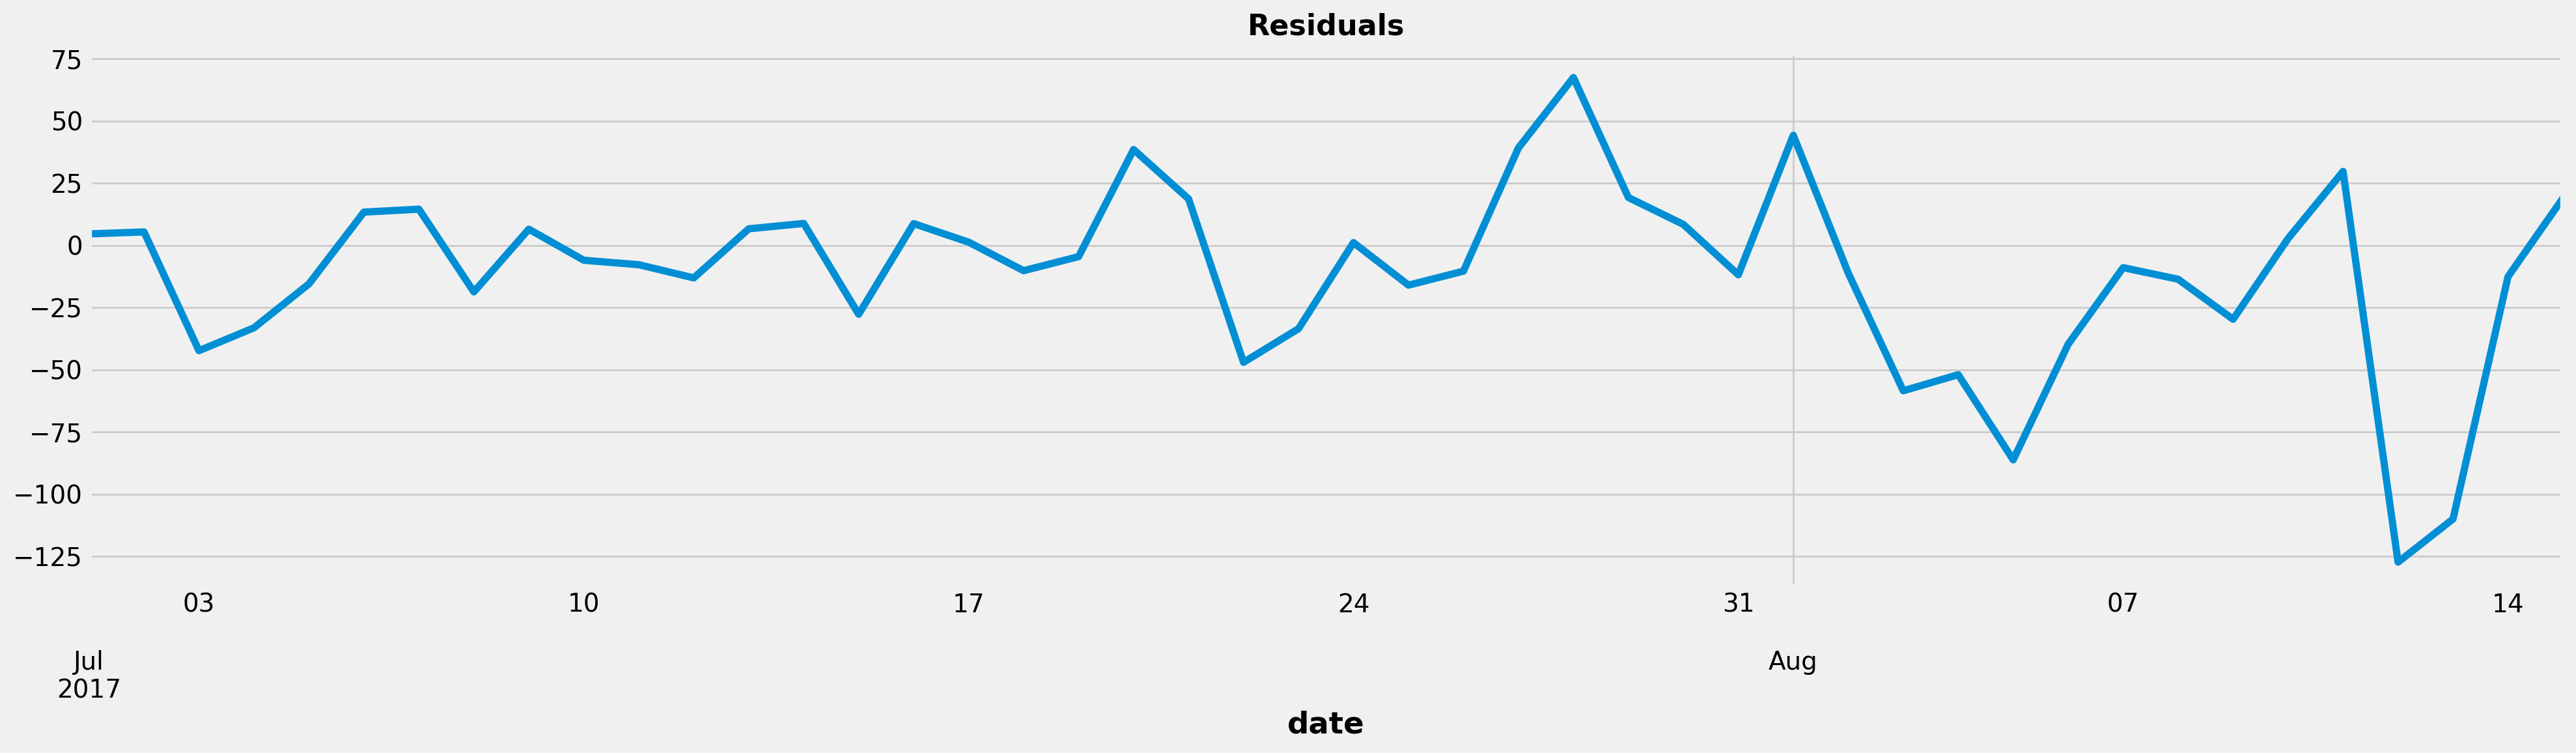

In [33]:
residuals = y_eval - y_fore
residuals.plot(title="Residuals");

- By visual inspection, it seems our model did quite well on the training data as residuals
- however, the variability in residuals doesn't look constant, and contains possible outliers
- Let's inspect the autocorrelation plot to see if the lags are significantly correlated with series

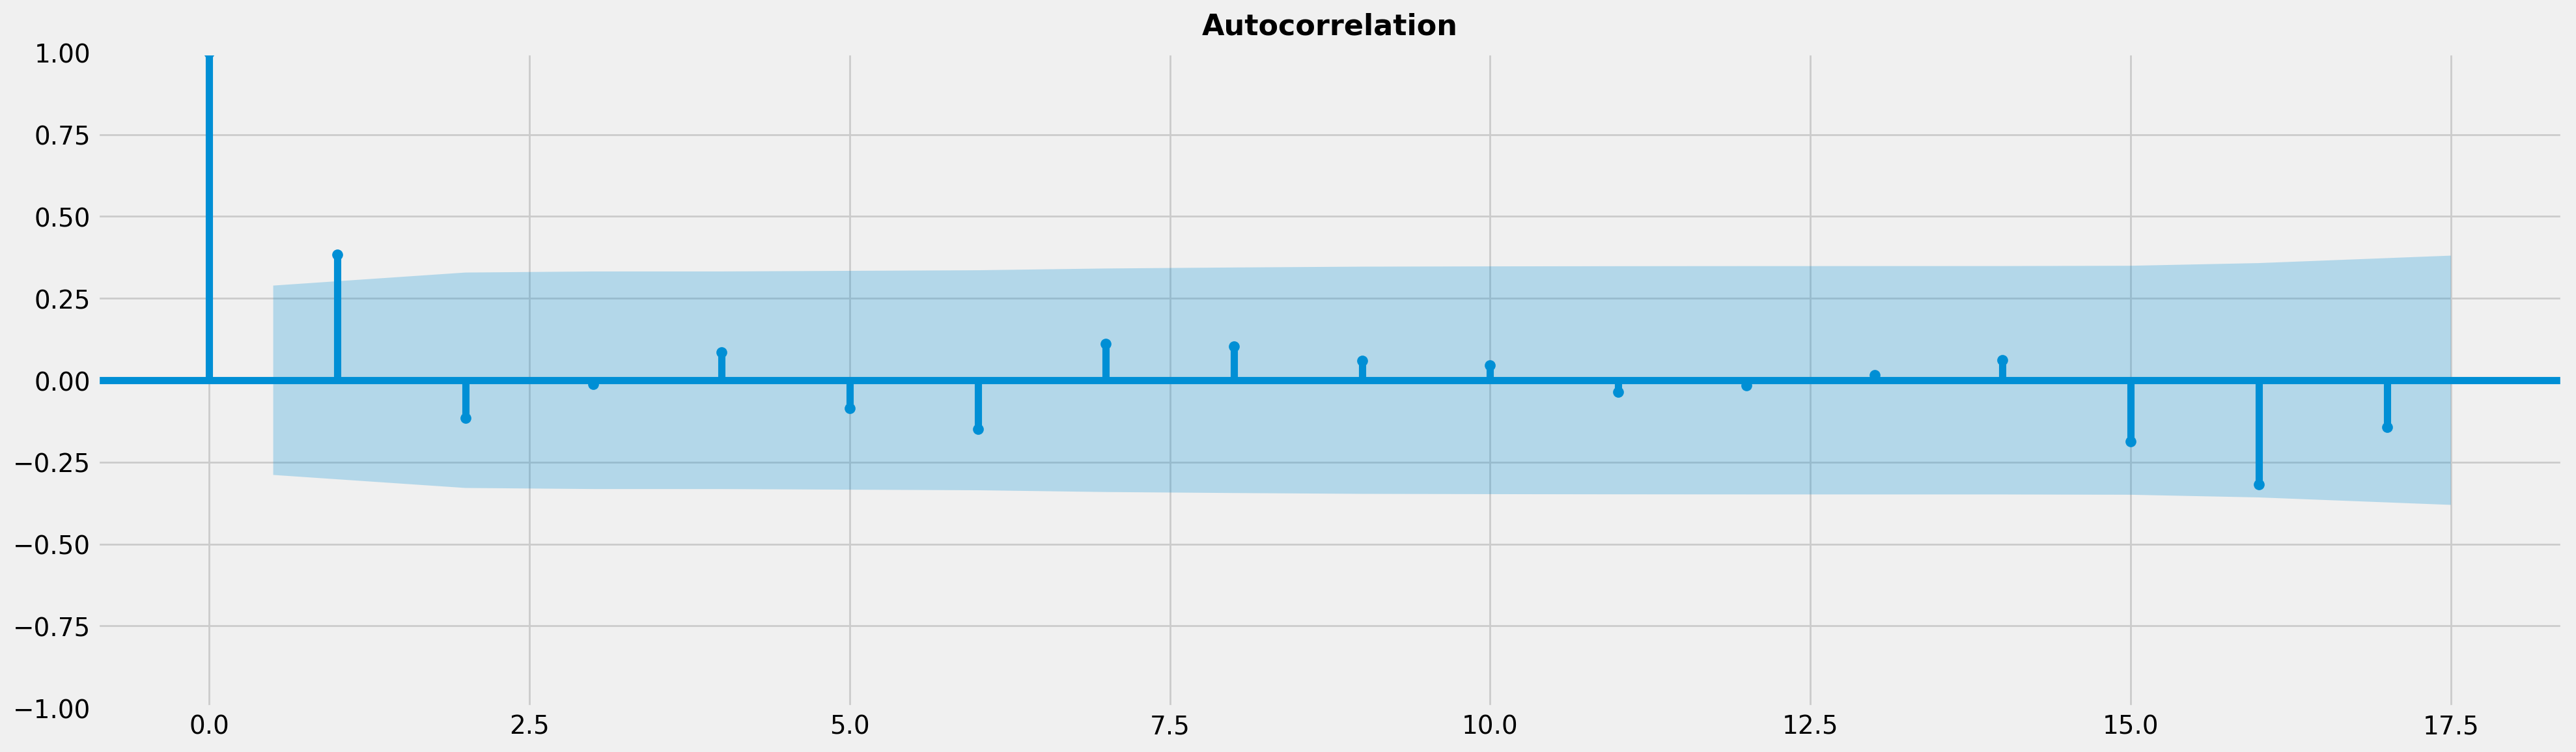

In [34]:
acf_plot = plot_acf(residuals)

- there is a significant lag (lag 1) indicating possible autocorrelation

- When we remove the trend or seasons from a time series, it's called detrending or deseasonalizing the series respectively
- Let's look at the periodogram of the deseasonalized series. 

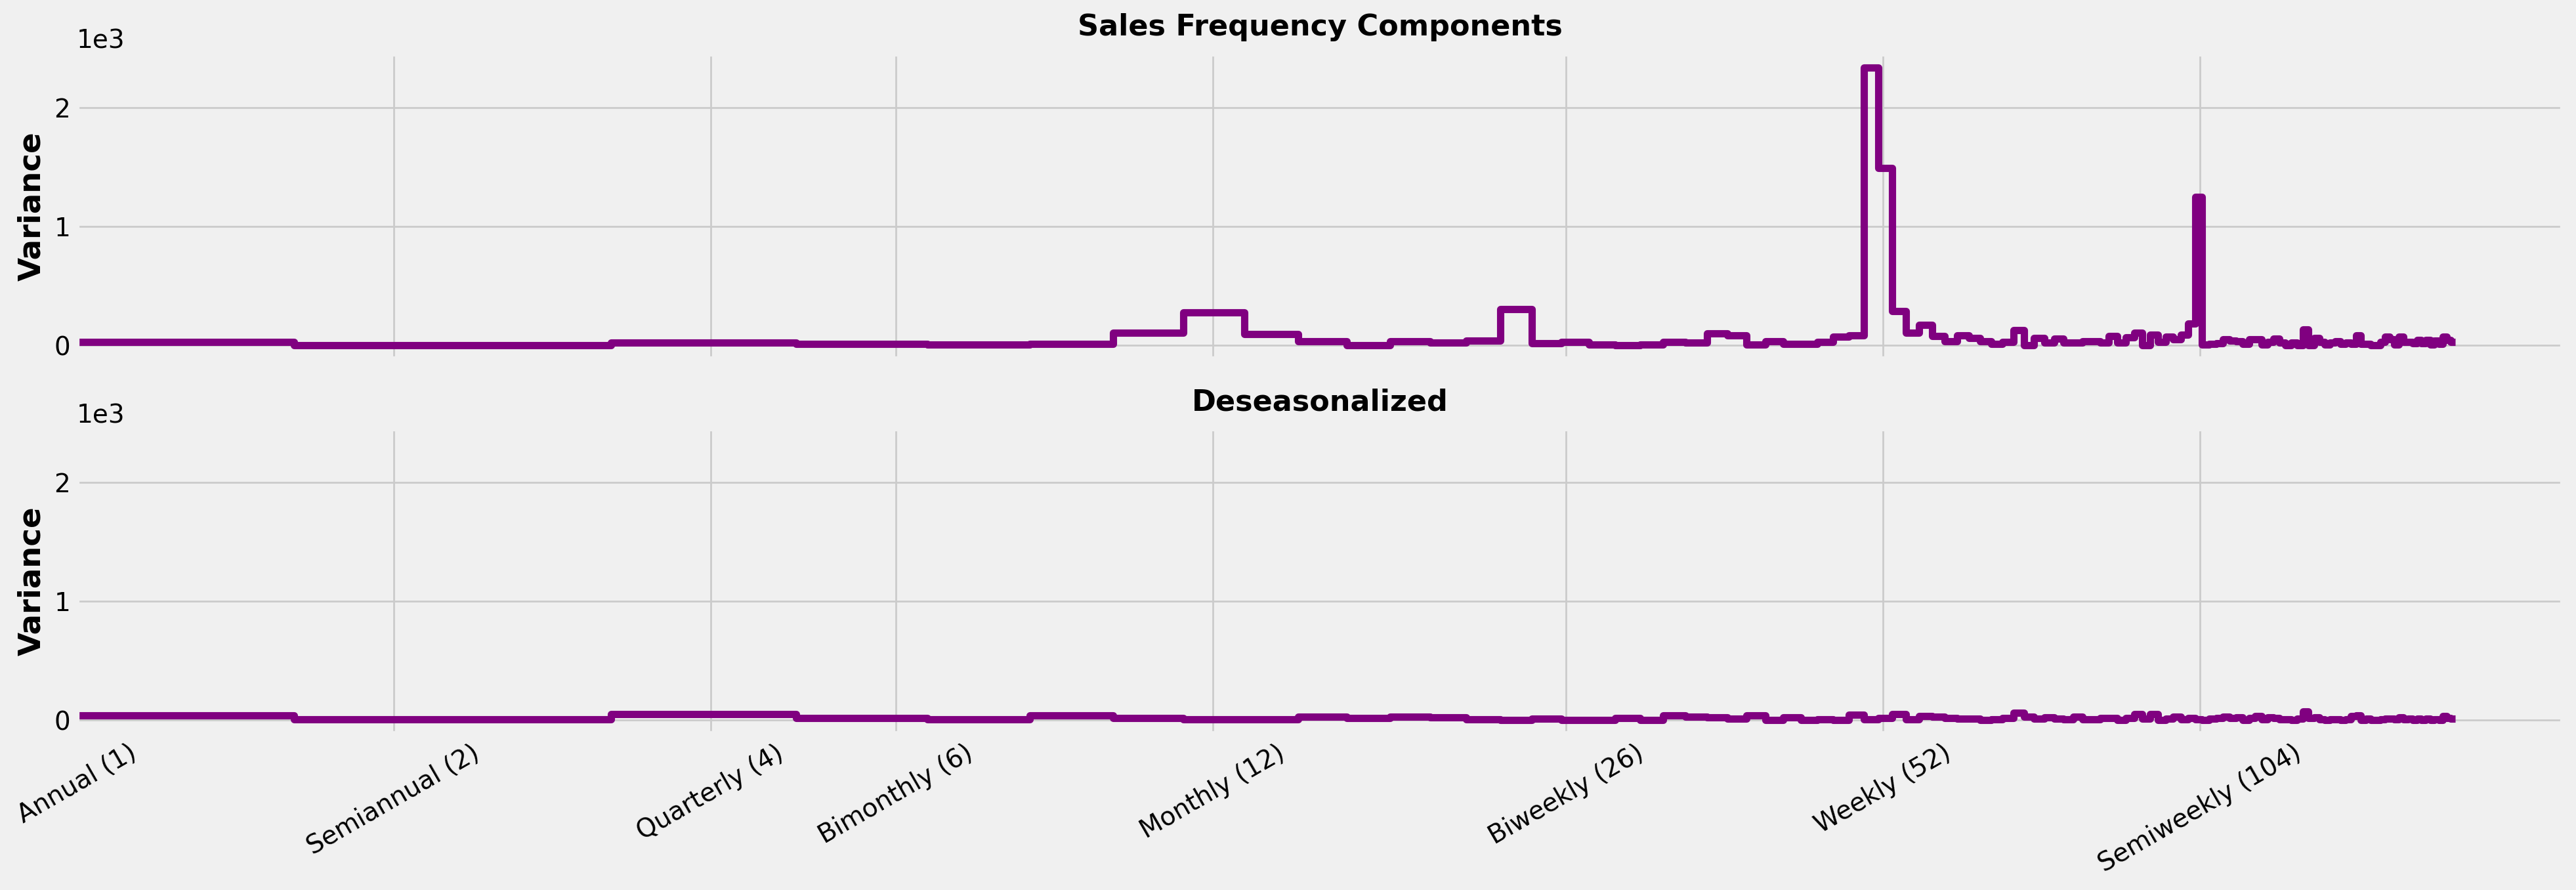

In [35]:
y_deseason = y - pd.concat([y_preds, y_fore])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 7))

plot_periodogram(y, ax=ax1)
ax1.set_title("Sales Frequency Components")
plot_periodogram(y_deseason, ax=ax2)
ax2.set_title("Deseasonalized");

Based on these periodograms, it appears the model effectively captured the seasonality in Average Sales. The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.

In [36]:
## evaluate performance

print("model performance with seasonal indicator and fourier features: ")
score_dataset(y_true=y_eval, y_pred=y_fore)

model performance with seasonal indicator and fourier features: 
MAPE: 5.561
RMSLE: 0.076


- We see a significant improvement in our model 
- let's investigate deseasonalized series

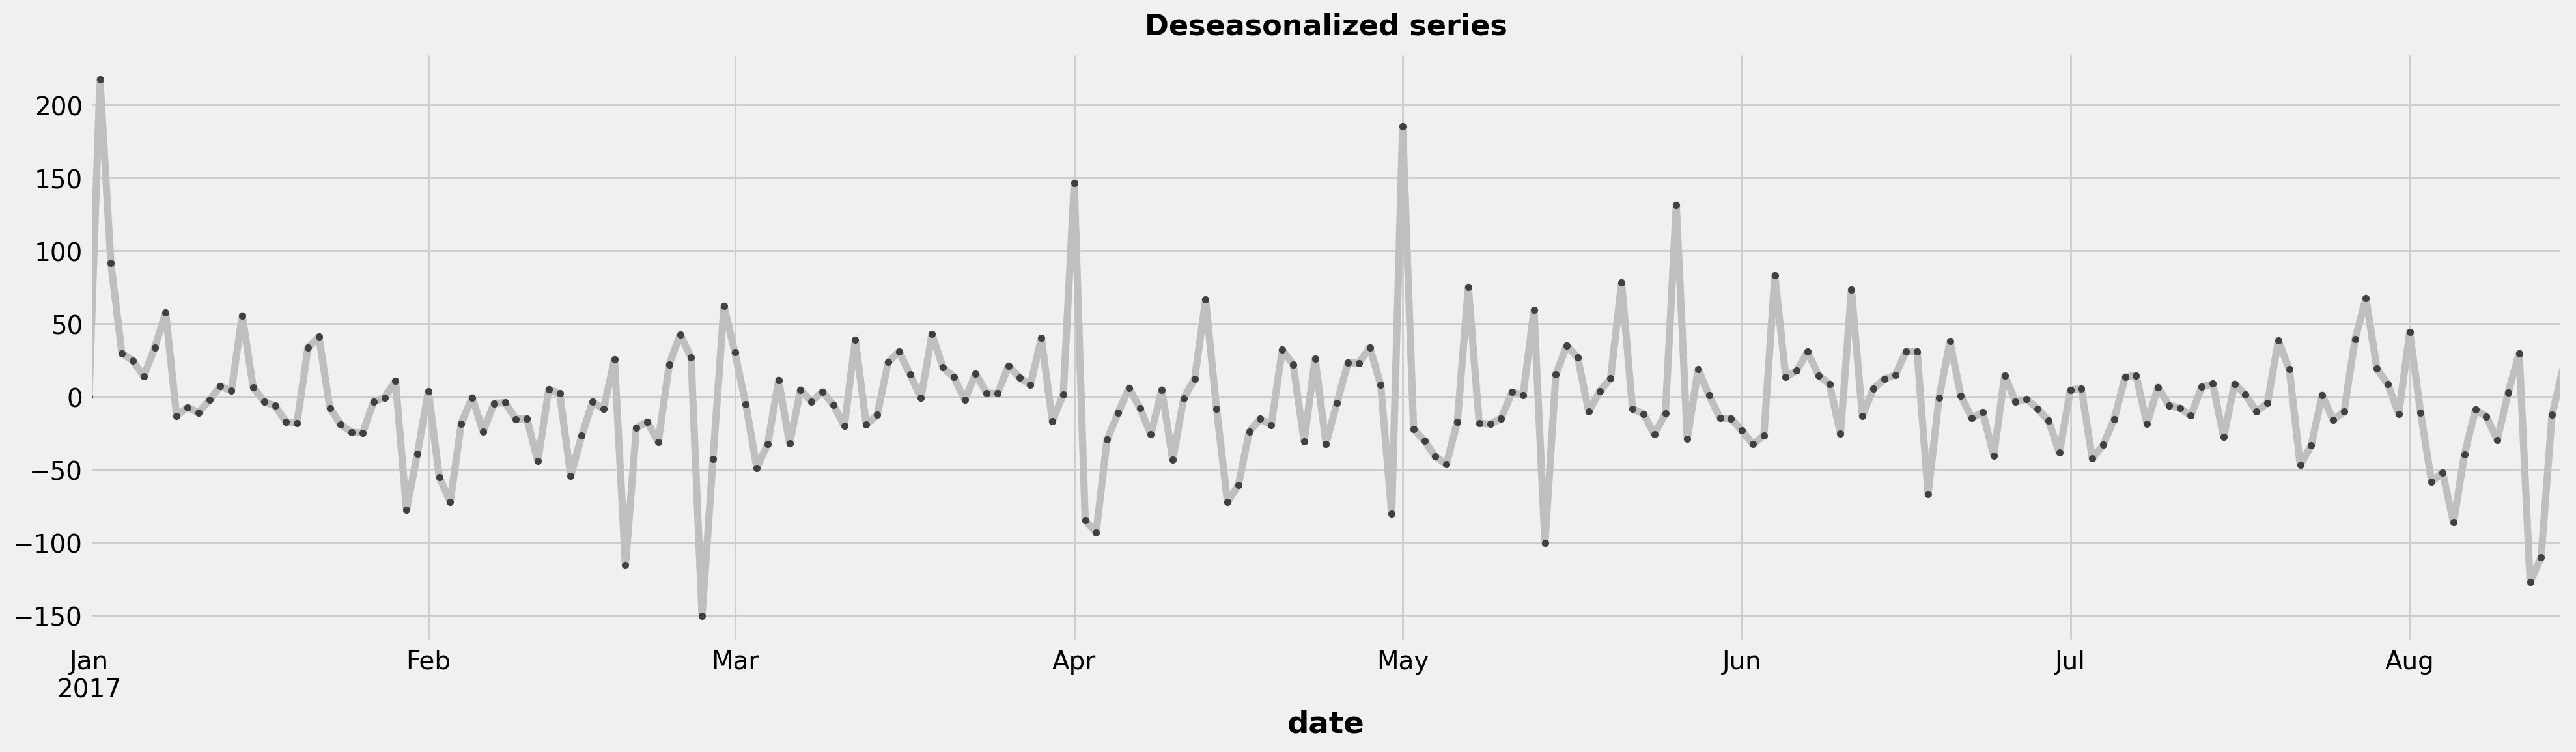

In [37]:
## plot deseasonalized series

y_deseason.plot(**plot_params, title="Deseasonalized series");

- There are spikes in the series which may be explained by other variaribles 
- The store sales dataset includes a table of Ecuadorian holidays

In [38]:
holidays = holiday_events.loc['2017-01-01':'2017-08-15', ["description"]]\
                        .assign(description= lambda x:x.description.cat.remove_unused_categories())  # remove unused categories to make one-hot encoding easy
              

oil_prices = oil.loc['2017-01-01':'2017-08-15']

In [39]:
## change DatetimeIndex to PeriodIndex for integration and plotting with average sales
holidays = holidays.to_period("D")
oil_prices = oil_prices.to_period("D")



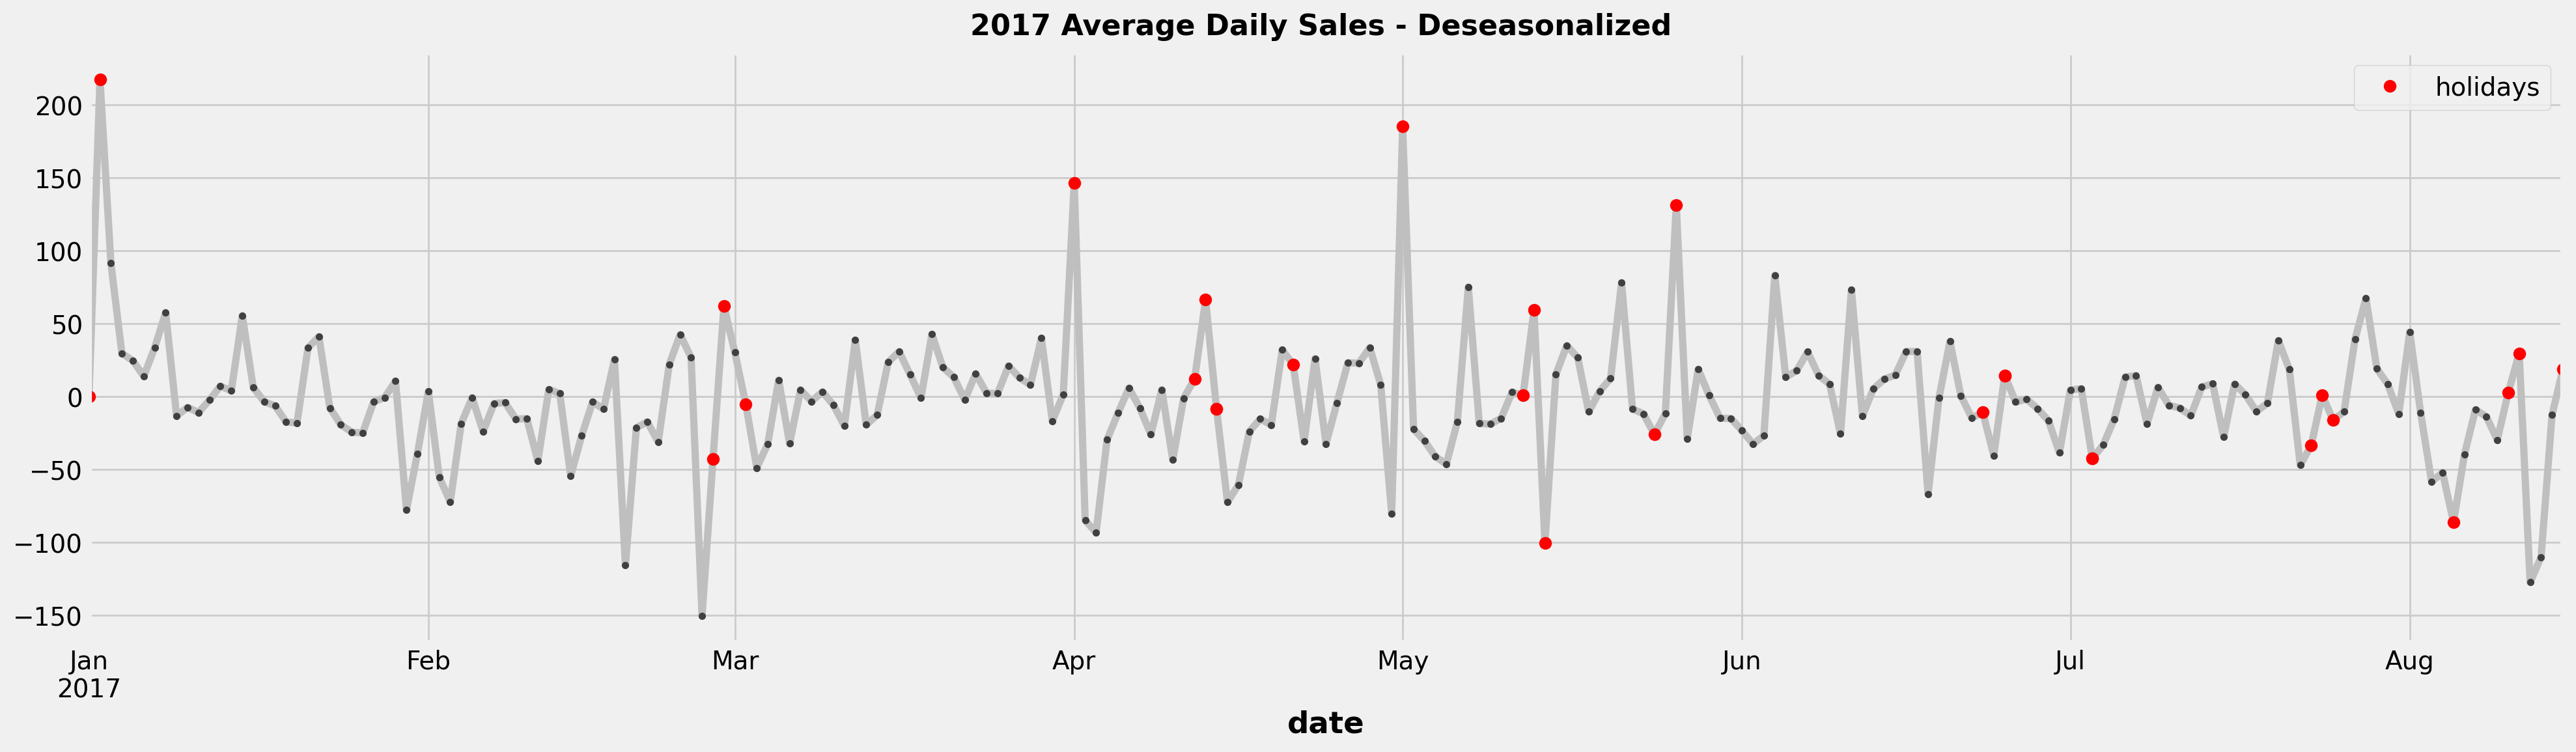

In [40]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color="red",  label="holidays")
ax.set_title("2017 Average Daily Sales - Deseasonalized ")
ax.legend();

- some of the sales spikes seems explainable by holiday events

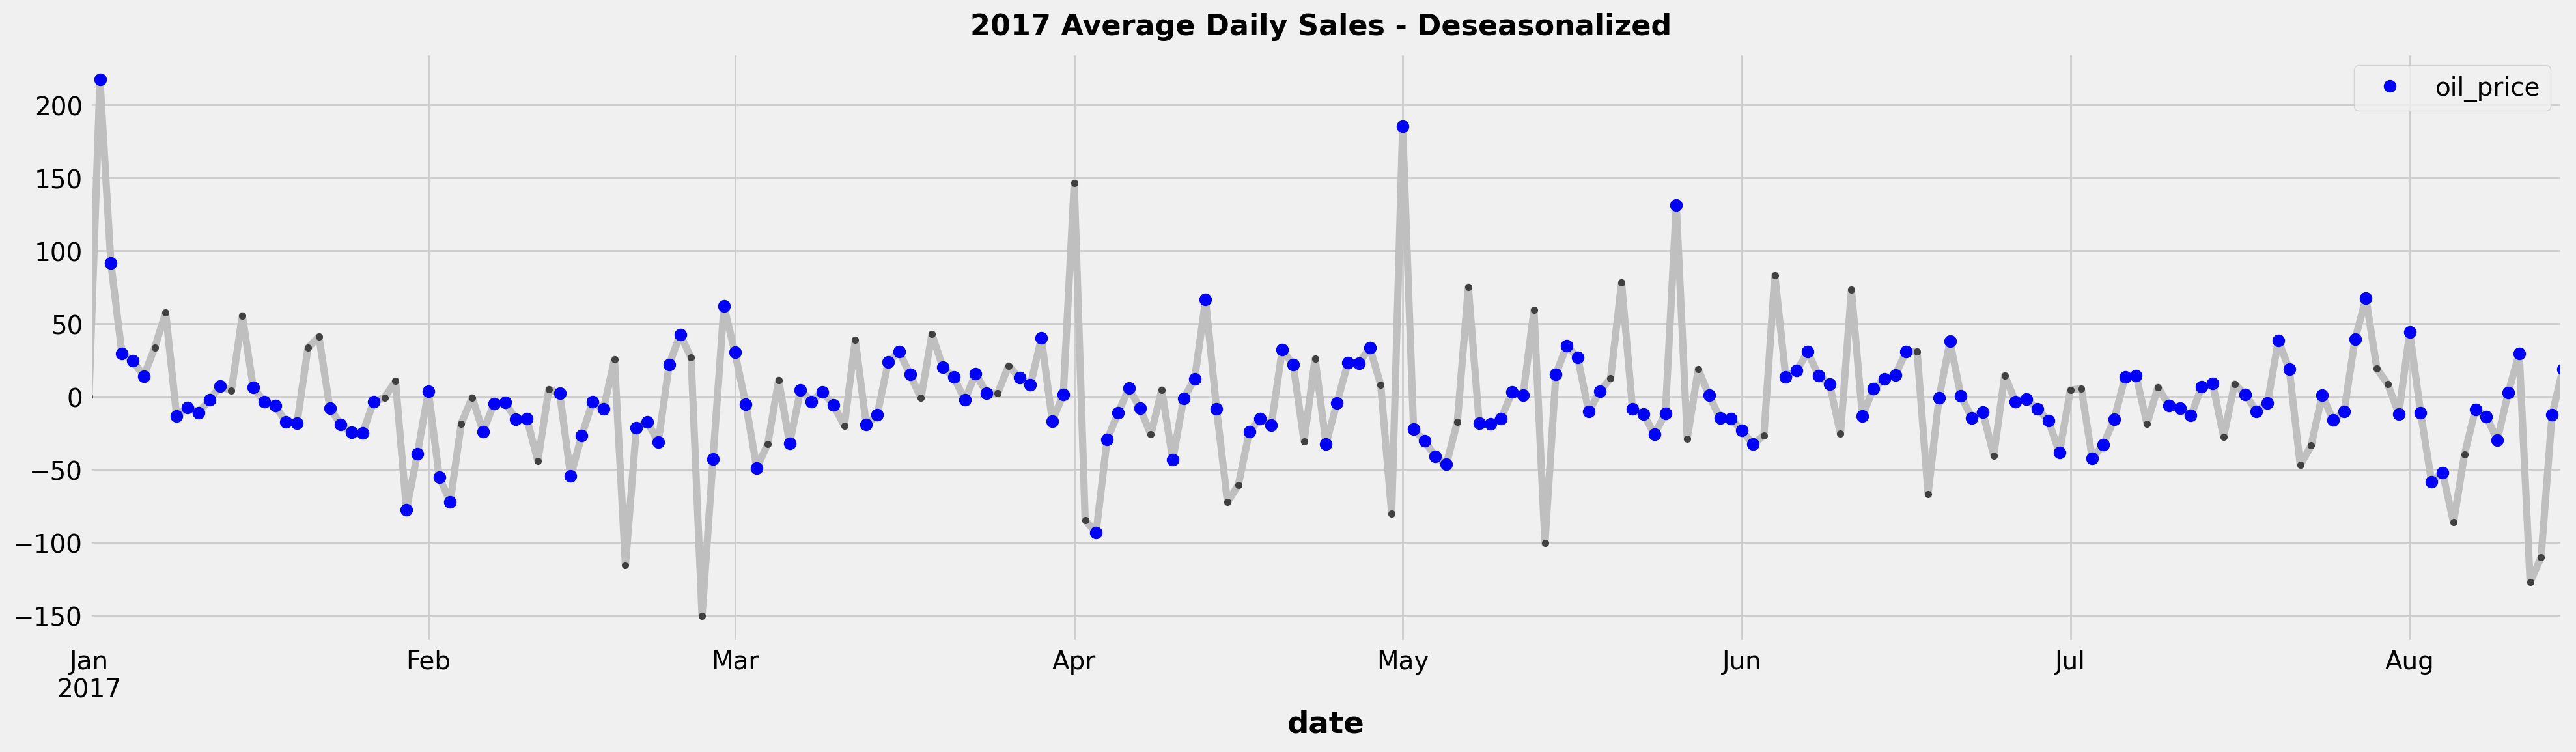

In [41]:
ax = y_deseason.plot(**plot_params)
ax.set_title("2017 Average Daily Sales - Deseasonalized ")
plt.plot_date(oil_prices.index, y_deseason[oil_prices.index], color="blue",  label="oil_price")
ax.legend();

- we see that sales spikes are likely explained by the holidays instead of the oil prices
- we'll include holiday features to help improve our model

In [42]:
## compute average across store for each product family

family_sales = (
    store_sales
    .groupby(["family", "date"], observed=False)
    .mean()
    .unstack("family")
    .loc["2017"]
)
family_sales

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222222  0.000000   
2017-01-02  11.481481  0.259259  11.648148  6208.055556  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814815  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833333  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796296  0.407407   
...               ...       ...        ...          ...       ...   
2017-08-11   8.166667  0.129630   6.500000  3502.055556  0.000000   
2017-08-12   7.462963  0.055556   6.833333  3376.259259  0.000000   
2017-08-13   8.907407  0.166667   8.018519  3747.296296  0.018519   
2017-08-14   5.407407  0.166667   6.240741  3237.629630  0.000000   
2017-08-15   6.240741  0.148148   6.277778  3162.462963  0.000000   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518519    3.629167   
2017-01-02   844.836296   14.203704  2233.648148  1545.000000  539.114833   
2017-01-03   665.124111   10.629630  1711.907407  1204.203704  404.300074   
2017-01-04   594.160611   11.185185  1508.037037  1107.796296  309.397685   
2017-01-05   495.511611   12.444444  1241.833333   829.277778  260.776500   
...                 ...         ...          ...          ...         ...   
2017-08-11   522.305296   16.111111  1031.148148   831.648148  345.934963   
2017-08-12   507.473111   15.722222  1072.870370   793.592593  290.553574   
2017-08-13   615.976981   10.074074  1143.648148   928.000000  325.801371   
2017-08-14   518.564019   11.000000  1019.111111   797.222222  271.532241   
2017-08-15   539.966574   11.055556  1082.851852   753.833333  276.582463   

            ... onpromotion                                        \
family      ...   MAGAZINES      MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                     
2017-01-01  ...         0.0   0.018519      0.111111     0.018519   
2017-01-02  ...         0.0   0.462963     10.592593     0.537037   
2017-01-03  ...         0.0   0.481481      9.722222     0.444444   
2017-01-04  ...         0.0   0.370370     12.037037     0.444444   
2017-01-05  ...         0.0   8.981481      5.666667     0.000000   
...         ...         ...        ...           ...          ...   
2017-08-11  ...         0.0  22.925926      9.000000     0.000000   
2017-08-12  ...         0.0   0.000000      8.703704     0.000000   
2017-08-13  ...         0.0   0.000000      9.240741     0.000000   
2017-08-14  ...         0.0   0.000000      8.722222     0.000000   
2017-08-15  ...         0.0   0.000000      8.814815     0.000000   

                                                                          \
family     PLAYERS AND ELECTRONICS    POULTRY PREPARED FOODS     PRODUCE   
date                                                                       
2017-01-01                0.000000   0.000000       0.037037    0.129630   
2017-01-02                0.000000   0.259259       1.166667    5.629630   
2017-01-03                0.000000   0.388889       1.351852   56.296296   
2017-01-04                0.000000   0.296296       5.444444  101.277778   
2017-01-05                0.000000   0.296296       0.907407    5.018519   
...                            ...        ...            ...         ...   
2017-08-11                0.000000  27.407407       0.537037    6.000000   
2017-08-12                0.018519   0.111111       0.277778    6.000000   
2017-08-13                0.000000   0.185185       0.222222    5.907407   
2017-08-14                0.000000   0.129630       0.148148    6.018519   
2017-08-15     

In [43]:
y = family_sales.loc[:, "sales"].copy()
y

family      AUTOMOTIVE  BABY CARE     BEAUTY    BEVERAGES     BOOKS  \
date                                                                  
2017-01-01    0.092593   0.037037   0.055556    74.222222  0.000000   
2017-01-02   11.481481   0.259259  11.648148  6208.055556  0.481481   
2017-01-03    8.296296   0.296296   7.185185  4507.814815  0.814815   
2017-01-04    6.833333   0.333333   6.888889  3911.833333  0.759259   
2017-01-05    6.333333   0.351852   5.925926  3258.796296  0.407407   
...                ...        ...        ...          ...       ...   
2017-08-11    8.166667   0.129630   6.500000  3502.055556  0.000000   
2017-08-12    7.462963   0.055556   6.833333  3376.259259  0.000000   
2017-08-13    8.907407   0.166667   8.018519  3747.296296  0.018519   
2017-08-14    5.407407   0.166667   6.240741  3237.629630  0.000000   
2017-08-15    6.240741   0.148148   6.277778  3162.462963  0.000000   

family      BREAD/BAKERY  CELEBRATION     CLEANING        DAIRY        DELI  \
date                                                                          
2017-01-01      9.084685     0.129630     7.500000    11.518519    3.629167   
2017-01-02    844.836296    14.203704  2233.648148  1545.000000  539.114833   
2017-01-03    665.124111    10.629630  1711.907407  1204.203704  404.300074   
2017-01-04    594.160611    11.185185  1508.037037  1107.796296  309.397685   
2017-01-05    495.511611    12.444444  1241.833333   829.277778  260.776500   
...                  ...          ...          ...          ...         ...   
2017-08-11    522.305296    16.111111  1031.148148   831.648148  345.934963   
2017-08-12    507.473111    15.722222  1072.870370   793.592593  290.553574   
2017-08-13    615.976981    10.074074  1143.648148   928.000000  325.801371   
2017-08-14    518.564019    11.000000  1019.111111   797.222222  271.532241   
2017-08-15    539.966574    11.055556  1082.851852   753.833333  276.582463   

family      ...  MAGAZINES       MEATS  PERSONAL CARE  PET SUPPLIES  \
date        ...                                                       
2017-01-01  ...   0.074074    5.013167       2.629630      0.074074   
2017-01-02  ...   7.777778  488.522332     714.370370     12.814815   
2017-01-03  ...   3.500000  427.520909     488.333333      8.870370   
2017-01-04  ...   3.500000  369.121482     426.574074      8.129630   
2017-01-05  ...   3.203704  368.945687     360.925926      7.629630   
...         ...        ...         ...            ...           ...   
2017-08-11  ...   9.259259  498.964667     295.888889     10.870370   
2017-08-12  ...   8.944444  329.178706     294.500000      9.407407   
2017-08-13  ...   8.685185  345.055834     336.814815     10.018519   
2017-08-14  ...   8.462963  314.364556     279.203704      7.722222   
2017-08-15  ...   8.537037  332.003166     273.833333      6.740741   

family      PLAYERS AND ELECTRONICS     POULTRY  PREPARED FOODS      PRODUCE  \
date                                                                           
2017-01-01                 0.222222    2.855537        1.040722    31.163778   
2017-01-02                22.777778  581.413130      153.555538  3409.500535   
2017-01-03                13.555556  462.013665      125.820537  3394.559756   
2017-01-04                12.092593  431.276409      116.740815  3467.447956   
2017-01-05                10.333333  345.673499      101.434574  2069.316630   
...                             ...         ...             ...          ...   
2017-08-11                12.111111  468.857370       96.286926  2198.854500   
2017-08-12                13.185185  354.342779       84.693815  2070.154646   
2017-08-13                13.722222  379.801204       91.509426  2331.922267   
2017-08-14                 9.259259  344.398297       86.062500  2134.399926   
2017-08-15                10.962963  325.679815       85.954129  2316.832796   

family      SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                           

To handle seasonalities and new year sales dip pattern. 

Engineering seasonal features and New year feature



In [44]:
## generate seasonal features 

fourier = CalendarFourier(freq="M", order=4)   # for fourier features

dp = DeterministicProcess(
    index=y.index,
    order=0, #  exclude trend feature
    constant=True,  # bias
    seasonal=True,  # generate seasonal indicators or dummy
    additional_terms=[fourier],
    drop=True,    
)
 
## seasonal features.  

X_1 = dp.in_sample()
X_1["NewYear"] = (X_1.index.dayofyear == 1)  # take care of the dip in sales 
X_1["Month"] = X_1.index.month
X_1

const  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                
2017-01-01    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    1.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-01-03    1.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-01-04    1.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-01-05    1.0     0.0     0.0     0.0     1.0     0.0     0.0   
...           ...     ...     ...     ...     ...     ...     ...   
2017-08-11    1.0     0.0     0.0     0.0     0.0     1.0     0.0   
2017-08-12    1.0     0.0     0.0     0.0     0.0     0.0     1.0   
2017-08-13    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-08-14    1.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-08-15    1.0     0.0     1.0     0.0     0.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
date                                                                     
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-02       0.201299       0.979530       0.394356       0.918958   
2017-01-03       0.394356       0.918958       0.724793       0.688967   
2017-01-04       0.571268       0.820763       0.937752       0.347305   
2017-01-05       0.724793       0.688967       0.998717      -0.050649   
...                   ...            ...            ...            ...   
2017-08-11       0.897805      -0.440394      -0.790776      -0.612106   
2017-08-12       0.790776      -0.612106      -0.968077      -0.250653   
2017-08-13       0.651372      -0.758758      -0.988468       0.151428   
2017-08-14       0.485302      -0.874347      -0.848644       0.528964   
2017-08-15       0.299363      -0.954139      -0.571268       0.820763   

            sin(3,freq=M)  cos(3,freq=M)  sin(4,freq=M)  cos(4,freq=M)  \
date                                                                     
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-02       0.571268       0.820763       0.724793       0.688967   
2017-01-03       0.937752       0.347305       0.998717      -0.050649   
2017-01-04       0.968077      -0.250653       0.651372      -0.758758   
2017-01-05       0.651372      -0.758758      -0.101168      -0.994869   
...                   ...            ...            ...            ...   
2017-08-11      -0.201299       0.979530       0.968077      -0.250653   
2017-08-12       0.394356       0.918958       0.485302      -0.874347   
2017-08-13       0.848644       0.528964      -0.299363      -0.954139   
2017-08-14       0.998717      -0.050649      -0.897805      -0.440394   
2017-08-15       0.790776      -0.612106      -0.937752       0.347305   

            NewYear  Month  
date                        
2017-01-01     True      1  
2017-01-02    False      1  
2017-01-03    False      1  
2017-01-04    False      1  
2017-01-05    False      1  
...             ...    ...  
2017-08-11    False      8  
2017-08-12    False      8  
2017-08-13    False      8  
2017-08-14    False      8  
2017-08-15    False      8  

[227 rows x 17 columns]

### Model Training

In [45]:
## df for tracking evaluation results
X_1_results = pd.DataFrame()

In [46]:
## define train test split function

def train_test_split(X, y):    
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]

    X_eval = X.loc[eval_idx]
    y_eval = y.loc[eval_idx]

    print("train: ", X_train.shape, y_train.shape)
    print("eval: ", X_eval.shape, y_eval.shape)
    return X_train, X_eval, y_train, y_eval


In [47]:
X_train, X_eval, y_train, y_eval = train_test_split(X=X_1, y=y)

train:  (181, 17) (181, 33)
eval:  (46, 17) (46, 33)


1. Linear Regression

since linear regression model is multi-output model, we could just pass in y as a dataframe without any preprocessing to a long format like some models

In [48]:
def score_model(model, X_train, X_eval, y_train, y_eval):

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_preds = pd.DataFrame(model.predict(X_eval), index=y_eval.index, columns=y_eval.columns)
    
    rmse = round(np.sqrt( mean_absolute_error(y_eval, y_preds) ), 2)
    #rmsle = round(np.sqrt( mean_squared_log_error(np.log1p(y_eval), np.log1p(y_preds)) ), 2)
    
    print("MSE: " , rmse)
   # print("RMSLE: ", rmsle)
    
    return y_preds, rmse #, rmsle
    

In [49]:
y_preds, lr_rmse = score_model(
                                    model=LinearRegression(), 
                                    X_train=X_train, 
                                    X_eval=X_eval, 
                                    y_train=y_train,
                                    y_eval=y_eval
                                )

MSE:  6.19


In [50]:
y_preds.head()

family      AUTOMOTIVE  BABY CARE    BEAUTY    BEVERAGES     BOOKS  \
date                                                                 
2017-07-01   11.342395   0.233138  7.874404  5058.599621 -0.030918   
2017-07-02   11.524124   0.254885  9.022464  5640.867130 -0.001498   
2017-07-03    8.219511   0.196869  6.104363  4123.392577 -0.027267   
2017-07-04    7.402145   0.148798  5.410816  3543.301709 -0.004439   
2017-07-05    6.970913   0.132061  4.949412  3241.914590  0.001640   

family      BREAD/BAKERY  CELEBRATION     CLEANING        DAIRY        DELI  \
date                                                                          
2017-07-01    713.257106    21.195714  1852.663690  1304.491702  457.163511   
2017-07-02    822.764101    13.498525  1904.984539  1449.772367  497.169833   
2017-07-03    625.572817    10.311284  1565.757568  1097.298588  379.370874   
2017-07-04    541.806706    10.789886  1371.469266   942.312524  323.127733   
2017-07-05    526.342653    11.765365  1304.908672   965.383437  284.127581   

family      ...  MAGAZINES       MEATS  PERSONAL CARE  PET SUPPLIES  \
date        ...                                                       
2017-07-01  ...   9.161154  452.352662     504.327673     14.186951   
2017-07-02  ...   7.797294  470.455426     558.514876     14.659516   
2017-07-03  ...   4.917379  379.671624     423.864189     10.097971   
2017-07-04  ...   4.035430  353.442902     356.676577      8.881465   
2017-07-05  ...   3.927529  324.853478     310.565741      8.432416   

family      PLAYERS AND ELECTRONICS     POULTRY  PREPARED FOODS      PRODUCE  \
date                                                                           
2017-07-01                17.298044  519.278633      119.995332  2909.434975   
2017-07-02                18.862015  559.775529      118.532913  3133.248448   
2017-07-03                12.976787  428.691454       86.259433  2490.775076   
2017-07-04                11.235232  373.914117       76.807174  2547.170536   
2017-07-05                10.505455  349.355372       80.089989  3039.242121   

family      SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                               
2017-07-01                   12.574822  27.864337  
2017-07-02                   13.003443  29.158285  
2017-07-03                    9.604144  21.105470  
2017-07-04                    7.566476  18.416892  
2017-07-05                    5.959506  18.685375  

[5 rows x 33 columns]

- from the training data average books series are particularly small values, hence predictor often predict a little below it resulting in negatives. we can take absolute values of the predictions so resolve this issue
- this way we can calculate rmsle without issues

In [51]:
## take absolute values of predictions in the score model function definition 

def score_model(model, X_train, X_eval, y_train, y_eval):
    
    model.fit(X_train, y_train)
    y_preds = pd.DataFrame(model.predict(X_eval), index=y_eval.index, columns=y_eval.columns)
    
    rmse = round(np.sqrt( mean_absolute_error(y_eval, y_preds)), 3)
    rmsle = round(np.sqrt( mean_squared_log_error(y_eval, y_preds.abs()) ), 3)
    
    print("MSE: " , rmse)
    print("RMSLE: ", rmsle)
    
    eval_dict = {"model": [str(model.__class__).split(".")[-1].rstrip("'>")], 'rmse': [rmse], "rmsle":[rmsle]}
    
    return model, y_preds, rmse, rmsle, eval_dict

In [52]:
lr_model, y_preds, lr_rmse, lr_rmsle, eval_dict = score_model(
                                                    model=LinearRegression(), 
                                                    X_train=X_train, 
                                                    X_eval=X_eval, 
                                                    y_train=y_train,
                                                    y_eval=y_eval
                                                )
X_1_results = pd.concat([X_1_results, pd.DataFrame(eval_dict)], axis=0, ignore_index=True)

MSE:  6.189
RMSLE:  0.286


In [53]:
# Retrieve the feature importance (coefficients)
#feature_importance = pd.Series(lr_fitted_model.coef_, index=X_train.columns).abs().sort_values(ascending=False)
#print(feature_importance)

2. Decision Tree Regressor


In [54]:
Dtree_model, y_preds, lr_rmse, lr_rmsle, eval_dict = score_model(
                                                    model=DecisionTreeRegressor(), 
                                                    X_train=X_train, 
                                                    X_eval=X_eval, 
                                                    y_train=y_train,
                                                    y_eval=y_eval
                                                )
X_1_results = pd.concat([X_1_results, pd.DataFrame(eval_dict)], axis=0, ignore_index=True)

MSE:  7.311
RMSLE:  0.457


3. Random Forest Regressor

In [55]:
Rforest_model, y_preds, lr_rmse, lr_rmsle, eval_dict  = score_model(
                                    model=RandomForestRegressor(), 
                                    X_train=X_train, 
                                    X_eval=X_eval, 
                                    y_train=y_train,
                                    y_eval=y_eval
                                )
X_1_results = pd.concat([X_1_results, pd.DataFrame(eval_dict)], axis=0, ignore_index=True)

MSE:  6.467
RMSLE:  0.343


4. XGBoost

In [56]:
xgb_model, y_preds, lr_rmse, lr_rmsle, eval_dict = score_model(
                                    model=XGBRegressor(), 
                                    X_train=X_train, 
                                    X_eval=X_eval, 
                                    y_train=y_train,
                                    y_eval=y_eval
                                )
X_1_results = pd.concat([X_1_results, pd.DataFrame(eval_dict)], axis=0, ignore_index=True)

MSE:  7.015
RMSLE:  0.366


In [57]:
X_1_results

model   rmse  rmsle
0       LinearRegression  6.189  0.286
1  DecisionTreeRegressor  7.311  0.457
2  RandomForestRegressor  6.467  0.343
3           XGBRegressor  7.015  0.366

### Let's include the `onpromotion` feature to the training see if there'll be an improvement: X_2

In [58]:
X_onpromotion = family_sales.loc[:, "onpromotion"]
X_onpromotion

family      AUTOMOTIVE  BABY CARE    BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                          
2017-01-01    0.000000   0.000000  0.000000   0.703704    0.0      0.055556   
2017-01-02    0.222222   0.000000  0.481481  42.314815    0.0      1.907407   
2017-01-03    0.111111   0.000000  0.444444  41.000000    0.0      2.000000   
2017-01-04    0.111111   0.000000  0.925926  55.222222    0.0      6.925926   
2017-01-05    0.092593   0.018519  0.907407  31.166667    0.0      6.222222   
...                ...        ...       ...        ...    ...           ...   
2017-08-11    0.000000   0.000000  0.870370  17.796296    0.0      8.907407   
2017-08-12    0.018519   0.000000  1.000000  17.703704    0.0      8.833333   
2017-08-13    0.000000   0.000000  1.018519  18.259259    0.0     32.222222   
2017-08-14    0.000000   0.000000  0.925926  17.722222    0.0      9.074074   
2017-08-15    0.018519   0.000000  1.018519  18.185185    0.0      9.481481   

family      CELEBRATION   CLEANING      DAIRY       DELI  ...  MAGAZINES  \
date                                                      ...              
2017-01-01     0.000000   0.203704   0.222222   0.166667  ...        0.0   
2017-01-02     0.351852  14.166667  13.518519   9.018519  ...        0.0   
2017-01-03     0.370370  15.092593  13.870370   8.944444  ...        0.0   
2017-01-04     0.407407  18.462963  71.925926   8.666667  ...        0.0   
2017-01-05     0.185185  12.814815  18.944444   0.629630  ...        0.0   
...                 ...        ...        ...        ...  ...        ...   
2017-08-11     0.000000  17.166667  18.203704  55.074074  ...        0.0   
2017-08-12     0.018519  16.925926  18.555556   6.444444  ...        0.0   
2017-08-13     0.000000  17.000000  18.462963   6.814815  ...        0.0   
2017-08-14     0.000000  15.555556  18.111111   6.592593  ...        0.0   
2017-08-15     0.000000  15.574074  18.092593   6.314815  ...        0.0   

family          MEATS  PERSONAL CARE  PET SUPPLIES  PLAYERS AND ELECTRONICS  \
date                                                                          
2017-01-01   0.018519       0.111111      0.018519                 0.000000   
2017-01-02   0.462963      10.592593      0.537037                 0.000000   
2017-01-03   0.481481       9.722222      0.444444                 0.000000   
2017-01-04   0.370370      12.037037      0.444444                 0.000000   
2017-01-05   8.981481       5.666667      0.000000                 0.000000   
...               ...            ...           ...                      ...   
2017-08-11  22.925926       9.000000      0.000000                 0.000000   
2017-08-12   0.000000       8.703704      0.000000                 0.018519   
2017-08-13   0.000000       9.240741      0.000000                 0.000000   
2017-08-14   0.000000       8.722222      0.000000                 0.000000   
2017-08-15   0.000000       8.814815      0.000000                 0.092593   

family        POULTRY  PREPARED FOODS     PRODUCE  SCHOOL AND OFFICE SUPPLIES  \
date                                                                            
2017-01-01   0.000000        0.037037    0.129630                    0.000000   
2017-01-02   0.259259        1.166667    5.629630                    0.000000   
2017-01-03   0.388889        1.351852   56.296296                    0.000000   
2017-01-04   0.296296        5.444444  101.277778                    0.000000   
2017-01-05   0.296296        0.907407    5.018519                    0.000000   
...               ...             ...         ...                         ...   
2017-08-11  27.407407        0.537037    6.000000                    2.666667   
2017-08-12   0.111111        0.277778    6.000000                    2.759259   
2017-08-13   0.185185        0.222222    5.907407                    2.777778   
2017-08-14   0.129630        0.148148    6.018519               

In [59]:
X_2 = pd.concat([X_1, X_onpromotion] , axis=1)
X_2.head()

const  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                
2017-01-01    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    1.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-01-03    1.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-01-04    1.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-01-05    1.0     0.0     0.0     0.0     1.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  ...  MAGAZINES  \
date                                                     ...              
2017-01-01       0.000000       1.000000       0.000000  ...        0.0   
2017-01-02       0.201299       0.979530       0.394356  ...        0.0   
2017-01-03       0.394356       0.918958       0.724793  ...        0.0   
2017-01-04       0.571268       0.820763       0.937752  ...        0.0   
2017-01-05       0.724793       0.688967       0.998717  ...        0.0   

               MEATS  PERSONAL CARE  PET SUPPLIES  PLAYERS AND ELECTRONICS  \
date                                                                         
2017-01-01  0.018519       0.111111      0.018519                      0.0   
2017-01-02  0.462963      10.592593      0.537037                      0.0   
2017-01-03  0.481481       9.722222      0.444444                      0.0   
2017-01-04  0.370370      12.037037      0.444444                      0.0   
2017-01-05  8.981481       5.666667      0.000000                      0.0   

             POULTRY  PREPARED FOODS     PRODUCE  SCHOOL AND OFFICE SUPPLIES  \
date                                                                           
2017-01-01  0.000000        0.037037    0.129630                         0.0   
2017-01-02  0.259259        1.166667    5.629630                         0.0   
2017-01-03  0.388889        1.351852   56.296296                         0.0   
2017-01-04  0.296296        5.444444  101.277778                         0.0   
2017-01-05  0.296296        0.907407    5.018519                         0.0   

             SEAFOOD  
date                  
2017-01-01  0.000000  
2017-01-02  0.407407  
2017-01-03  0.407407  
2017-01-04  0.333333  
2017-01-05  0.444444  

[5 rows x 50 columns]

In [60]:
## split data

X_train, X_eval, y_train, y_eval = train_test_split(X=X_2, y=y)

train:  (181, 50) (181, 33)
eval:  (46, 50) (46, 33)


In [61]:
## results df
X_2_results = pd.DataFrame()

In [62]:
lr_model, y_preds, lr_rmse, lr_rmsle, eval_dict = score_model(
                                                    model=LinearRegression(), 
                                                    X_train=X_train, 
                                                    X_eval=X_eval, 
                                                    y_train=y_train,
                                                    y_eval=y_eval
                                                )
X_2_results = pd.concat([X_2_results, pd.DataFrame(eval_dict)], axis=0, ignore_index=True)

MSE:  9.128
RMSLE:  0.481


In [63]:
Dtree_model, y_preds, lr_rmse, lr_rmsle, eval_dict = score_model(
                                                    model=DecisionTreeRegressor(), 
                                                    X_train=X_train, 
                                                    X_eval=X_eval, 
                                                    y_train=y_train,
                                                    y_eval=y_eval
                                                )
X_2_results = pd.concat([X_2_results, pd.DataFrame(eval_dict)], axis=0, ignore_index=True)

MSE:  7.775
RMSLE:  0.471


In [64]:
Rforest_model, y_preds, lr_rmse, lr_rmsle, eval_dict  = score_model(
                                    model=RandomForestRegressor(), 
                                    X_train=X_train, 
                                    X_eval=X_eval, 
                                    y_train=y_train,
                                    y_eval=y_eval
                                )
X_2_results = pd.concat([X_2_results, pd.DataFrame(eval_dict)], axis=0, ignore_index=True)

MSE:  6.392
RMSLE:  0.299


In [65]:
xgb_model, y_preds, lr_rmse, lr_rmsle, eval_dict = score_model(
                                    model=XGBRegressor(), 
                                    X_train=X_train, 
                                    X_eval=X_eval, 
                                    y_train=y_train,
                                    y_eval=y_eval
                                )
X_2_results = pd.concat([X_2_results, pd.DataFrame(eval_dict)], axis=0, ignore_index=True)

MSE:  6.78
RMSLE:  0.215


In [66]:
pd.concat([X_1_results, X_2_results], 
          keys=(["X_1 feature matrix", "X_2 feature matrix"]), axis=1 )

X_1 feature matrix                   X_2 feature matrix              
                   model   rmse  rmsle                  model   rmse  rmsle
0       LinearRegression  6.189  0.286       LinearRegression  9.128  0.481
1  DecisionTreeRegressor  7.311  0.457  DecisionTreeRegressor  7.775  0.471
2  RandomForestRegressor  6.467  0.343  RandomForestRegressor  6.392  0.299
3           XGBRegressor  7.015  0.366           XGBRegressor  6.780  0.215

- XGBoost is primarily designed for single-output regression and classification tasks, but it may still accept a multi-output data frame without throwing an error. 
- However, the model might not be effectively utilizing the multi-output nature of the data, and the results may not be as expected.
- we preprocess our data so that xgboost can work with data with single-output nature

In [67]:
# X_2: Features for XGBoost. 
X_onpromotion = family_sales.stack().drop("sales", axis=1).reset_index("family")

# Label encoding for "family"
X_onpromotion["family"], _ = X_onpromotion["family"].factorize()

X_onpromotion

family  onpromotion
date                           
2017-01-01       0     0.000000
2017-01-01       1     0.000000
2017-01-01       2     0.000000
2017-01-01       3     0.703704
2017-01-01       4     0.000000
...            ...          ...
2017-08-15      28     0.111111
2017-08-15      29     0.166667
2017-08-15      30    58.685185
2017-08-15      31     2.740741
2017-08-15      32     0.000000

[7491 rows x 2 columns]

In [68]:
X_3 = pd.concat([X_1, X_onpromotion ], axis=1)
X_3

const  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                
2017-01-01    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-01    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-01    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-01    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-01    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
...           ...     ...     ...     ...     ...     ...     ...   
2017-08-15    1.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-08-15    1.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-08-15    1.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-08-15    1.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-08-15    1.0     0.0     1.0     0.0     0.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
date                                                                     
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-01       0.000000       1.000000       0.000000       1.000000   
...                   ...            ...            ...            ...   
2017-08-15       0.299363      -0.954139      -0.571268       0.820763   
2017-08-15       0.299363      -0.954139      -0.571268       0.820763   
2017-08-15       0.299363      -0.954139      -0.571268       0.820763   
2017-08-15       0.299363      -0.954139      -0.571268       0.820763   
2017-08-15       0.299363      -0.954139      -0.571268       0.820763   

            sin(3,freq=M)  cos(3,freq=M)  sin(4,freq=M)  cos(4,freq=M)  \
date                                                                     
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-01       0.000000       1.000000       0.000000       1.000000   
...                   ...            ...            ...            ...   
2017-08-15       0.790776      -0.612106      -0.937752       0.347305   
2017-08-15       0.790776      -0.612106      -0.937752       0.347305   
2017-08-15       0.790776      -0.612106      -0.937752       0.347305   
2017-08-15       0.790776      -0.612106      -0.937752       0.347305   
2017-08-15       0.790776      -0.612106      -0.937752       0.347305   

            NewYear  Month  family  onpromotion  
date                                             
2017-01-01     True      1       0     0.000000  
2017-01-01     True      1       1     0.000000  
2017-01-01     True      1       2     0.000000  
2017-01-01     True      1       3     0.703704  
2017-01-01     True      1       4     0.000000  
...             ...    ...     ...          ...  
2017-08-15    False      8      28     0.111111  
2017-08-15    False      8      29     0.166667  
2017-08-15    False      8      30    58.685185  
2017-08-15    False      8      31     2.740741  
2017-08-15    False      8      32     0.000000  

[7491 rows x 19 columns]

In [69]:
## split data
X_train, X_eval, y_train, y_eval = train_test_split(X=X_3, y=y.stack())

train:  (5973, 19) (5973,)
eval:  (1518, 19) (1518,)


In [70]:
y_train.head().index

MultiIndex([('2017-01-01', 'AUTOMOTIVE'),
            ('2017-01-01',  'BABY CARE'),
            ('2017-01-01',     'BEAUTY'),
            ('2017-01-01',  'BEVERAGES'),
            ('2017-01-01',      'BOOKS')],
           names=['date', 'family'])

In [71]:
model = XGBRegressor()
model.fit(X_train, y_train)
y_preds = pd.DataFrame(model.predict(X_eval), index=y_eval.index, columns=["sales"])

rmse = round(np.sqrt( mean_absolute_error(y_eval, y_preds)), 3)
rmsle = round(np.sqrt( mean_squared_log_error(y_eval, y_preds.abs()) ), 3)

print("MSE: " , rmse)
print("RMSLE: ", rmsle)

MSE:  8.247
RMSLE:  0.797


In [72]:
y_preds

sales
date       family                                 
2017-07-01 AUTOMOTIVE                    59.441822
           BABY CARE                      7.200467
           BEAUTY                       238.885620
           BEVERAGES                   6210.360840
           BOOKS                          6.041372
...                                            ...
2017-08-15 POULTRY                      327.221161
           PREPARED FOODS                83.041290
           PRODUCE                     2468.967529
           SCHOOL AND OFFICE SUPPLIES    13.842204
           SEAFOOD                       12.981438

[1518 rows x 1 columns]

### Model Imrprovement 
Ultimatly X_2 feature matrix and xgboost regressor has the best rmsle

In [73]:
X_train, X_eval, y_train, y_eval = train_test_split(X=X_2, y=y)

train:  (181, 50) (181, 33)
eval:  (46, 50) (46, 33)


In [94]:
booster="gbtree"
n_estimators = 100
max_depth = 3
learning_rate = 0.3
colsample_bylevel=0.5



model = XGBRegressor(
                    booster=booster, 
                    n_estimators=n_estimators,
                    max_depth=max_depth,  
                    learning_rate=learning_rate,
                    colsample_bylevel=colsample_bylevel
                    )
model.fit(X_train, y_train)
y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns)
y_preds = pd.DataFrame(model.predict(X_eval), index=X_eval.index, columns=y_eval.columns)

print("Train: ")
rmse = round(np.sqrt( mean_absolute_error(y_train, y_fit)), 3)
rmsle = round(np.sqrt( mean_squared_log_error(y_train, y_fit.abs()) ), 3)

print("MSE: " , rmse)
print("RMSLE: ", rmsle)
print()

print("validation: ")
rmse = round(np.sqrt( mean_absolute_error(y_eval, y_preds)), 3)
rmsle = round(np.sqrt( mean_squared_log_error(y_eval, y_preds.abs()) ), 3)

print("MSE: " , rmse)
print("RMSLE: ", rmsle)

Train: 
MSE:  1.138
RMSLE:  0.012

validation: 
MSE:  6.706
RMSLE:  0.218


In [96]:
model

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### save trained model 

In [98]:
with open("../models/trained_model.pkl", "wb") as f:
    pickle.dump(model, f)
